# Import

In [5]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from BI import bi
from jax import jit
from functools import partial
import time as tm
import numpy as np
import jax.numpy as jnp
# Bi modules
m = bi(platform='cpu')

jax.local_device_count 16


# Networks Models

## Rethinking

In [7]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)

m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.run(model) 
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 260.89it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 5.9322 seconds


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Trying bi functions

In [ ]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
res2 = az.from_numpyro(m.sampler)

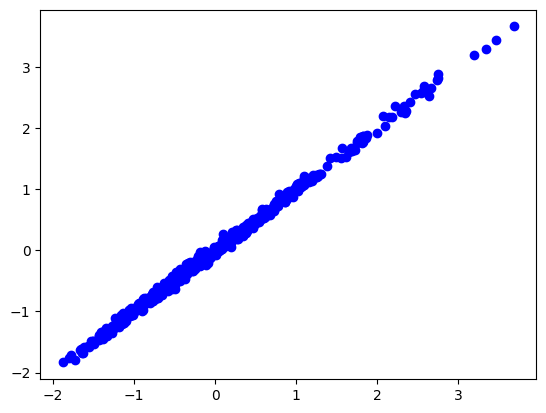

In [ ]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0], marker='o', linestyle='None', color='b', label='Posteriors')

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1], marker='o', linestyle='None', color='b', label='Posteriors')

## STRAND

### Utilities functions

In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri


#strand_posteriors = ro.r['strand_post']
def strand_to_dict(strand_posteriors):
    names = list(strand_posteriors.names)

    names = list(strand_posteriors.names)
    
    strand_p = {}
    
    # Use the localconverter to automatically handle R-to-NumPy conversion.
    with localconverter(ro.default_converter + numpy2ri.converter):
        for i, name in enumerate(names):
            strand_p[name] = np.array(strand_posteriors[i])
            
    return strand_p

def compare_results(BI_posteriors, strand_posteriors):
    mapping = {
        'sr_sigma': 'focal_target_sd' ,  # same
        'sr_L': 'focal_target_L' ,
        'receiver_effects':'target_coeffs' ,
        'sender_effects': 'focal_coeffs' ,
        'dr_L': 'dyadic_L',
        'dr_sigma': 'dyadic_sd',
        'dyad_effects': 'dyadic_coeffs',
        'dr_raw': 'dyadic_random_effects',
   
    }
    # --- Dynamic block parameters mapping ---
    block_keys = sorted([k for k in strand_posteriors.keys()
                    if k.startswith('block_parameters') or k.startswith('b_')])

    if len(block_keys) == 1:
        # Only one block → use b_intercept
        mapping['b_intecept'] = block_keys[0]
    else:
        # Multiple blocks → b_0, b_1, ...
        print(block_keys)
        for i, blk in enumerate(block_keys):
            print(blk)
            m_key = f"b_{i}"   # e.g. b_0, b_1
            mapping[blk] = blk

    import numpy as np
    print(mapping.keys())
    print(mapping.values())
    summaries = []

    for m_key, s_key  in mapping.items():
        # Get arrays
 
        arr_m = BI_posteriors[m_key]
        arr_s = strand_posteriors[s_key]

        # Handle dr_rf special case
        if m_key == 'dyadic_random_effects':
            arr_m = m.net.edlg_to_mat(arr_m)

        if m_key == 'sr_sigma':
            meanBI = arr_m.mean(axis=0)
            sdBI = arr_m.std(axis=0)
 
            meanS = arr_s.mean(axis=0)
            sdS = arr_s.std(axis=0)

            # Average across parameters for visual simplicity
            summaries.append({
                'param': 'sr_sigma1',
                'mean_m': meanBI[0],
                'sd_m': sdBI[0],
                'mean_s': meanS[0],
                'sd_s': sdS[0]
            })
            summaries.append({
                'param': 'sr_sigma2',
                'mean_m': meanBI[0],
                'sd_m': sdBI[0],
                'mean_s': meanS[0],
                'sd_s': sdS[0]
            })

        elif m_key == 'dr_raw':
            arr_sMEAN = m.net.mat_to_edgl(arr_s.mean(axis = 0))
            arr_sSTD = m.net.mat_to_edgl(arr_s.std(axis = 0))

            meanBI = arr_m.mean(axis=0)
            sdBI = arr_m.std(axis=0)
 
            meanS = arr_s.mean(axis=0)
            sdS = arr_s.std(axis=0)

            # Average across parameters for visual simplicity
            summaries.append({
                'param': 'dr_raw1',
                'mean_m': meanBI[0,:].mean(),
                'sd_m': sdBI[0,:].mean(),
                'mean_s': arr_sMEAN[0,:].mean(),
                'sd_s': arr_sSTD[0,:].mean()
            })
            summaries.append({
                'param': 'dr_raw2',
                'mean_m': meanBI[1,:].mean(),
                'sd_m': sdBI[1,:].mean(),
                'mean_s': arr_sMEAN[1,:].mean(),
                'sd_s': arr_sSTD[1,:].mean()
            })

        elif m_key == 'sr_L':
            meanBI = arr_m.mean(axis=0)
            sdBI = arr_m.std(axis=0)
 
            meanS = arr_s.mean(axis=0)
            sdS = arr_s.std(axis=0)

            # Average across parameters for visual simplicity
            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[0,0],
                'sd_m': sdBI[0,0],
                'mean_s': meanS[0,0],
                'sd_s': sdS[0,0]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[0,0],
                'sd_m': sdBI[0,0],
                'mean_s': meanS[0,0],
                'sd_s': sdS[0,0]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[0,1],
                'sd_m': sdBI[0,1],
                'mean_s': meanS[0,1],
                'sd_s': sdS[0,1]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[0,1],
                'sd_m': sdBI[0,1],
                'mean_s': meanS[0,1],
                'sd_s': sdS[0,1]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[1,0],
                'sd_m': sdBI[1,0],
                'mean_s': meanS[1,0],
                'sd_s': sdS[1,0]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[1,0],
                'sd_m': sdBI[1,0],
                'mean_s': meanS[1,0],
                'sd_s': sdS[1,0]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[1,1],
                'sd_m': sdBI[1,1],
                'mean_s': meanS[1,1],
                'sd_s': sdS[1,1]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[1,1],
                'sd_m': sdBI[1,1],
                'mean_s': meanS[1,1],
                'sd_s': sdS[1,1]
            })

        elif m_key == 'dr_L':
            meanBI = arr_m.mean(axis=0)
            sdBI = arr_m.std(axis=0)
 
            meanS = arr_s.mean(axis=0)
            sdS = arr_s.std(axis=0)

            # Average across parameters for visual simplicity
            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[0,0],
                'sd_m': sdBI[0,0],
                'mean_s': meanS[0,0],
                'sd_s': sdS[0,0]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[0,0],
                'sd_m': sdBI[0,0],
                'mean_s': meanS[0,0],
                'sd_s': sdS[0,0]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[0,1],
                'sd_m': sdBI[0,1],
                'mean_s': meanS[0,1],
                'sd_s': sdS[0,1]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[0,1],
                'sd_m': sdBI[0,1],
                'mean_s': meanS[0,1],
                'sd_s': sdS[0,1]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[1,0],
                'sd_m': sdBI[1,0],
                'mean_s': meanS[1,0],
                'sd_s': sdS[1,0]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[1,0],
                'sd_m': sdBI[1,0],
                'mean_s': meanS[1,0],
                'sd_s': sdS[1,0]
            })

            summaries.append({
                'param': 'sr_L1',
                'mean_m': meanBI[1,1],
                'sd_m': sdBI[1,1],
                'mean_s': meanS[1,1],
                'sd_s': sdS[1,1]
            })
            summaries.append({
                'param': 'sr_L2',
                'mean_m': meanBI[1,1],
                'sd_m': sdBI[1,1],
                'mean_s': meanS[1,1],
                'sd_s': sdS[1,1]
            })



        else:
            # Flatten to 1D (e.g. if multidimensional)
            arr_m = arr_m.reshape(arr_m.shape[0], -1)
            arr_s = arr_s.reshape(arr_s.shape[0], -1)

            # Compute means and sds for each parameter
            mean_m = arr_m.mean(axis=0)
            sd_m = arr_m.std(axis=0)

            mean_s = arr_s.mean(axis=0)
            sd_s = arr_s.std(axis=0)

            # Average across parameters for visual simplicity
            summaries.append({
                'param': m_key,
                'mean_m': mean_m.mean(),
                'sd_m': sd_m.mean(),
                'mean_s': mean_s.mean(),
                'sd_s': sd_s.mean()
            })
    import matplotlib.pyplot as plt

    params = [d['param'] for d in summaries]
    mean_m = np.array([d['mean_m'] for d in summaries])
    sd_m = np.array([d['sd_m'] for d in summaries])
    mean_s = np.array([d['mean_s'] for d in summaries])
    sd_s = np.array([d['sd_s'] for d in summaries])

    y = np.arange(len(params))

    plt.figure(figsize=(8, 6))
    plt.errorbar(mean_m, y + 0.1, xerr=sd_m, fmt='o', label='BI.posteriors', capsize=3)
    plt.errorbar(mean_s, y - 0.1, xerr=sd_s, fmt='o', label='strand_p', capsize=3)
    plt.yticks(y, params)
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Posterior mean ± 1 SD')
    plt.legend()
    plt.title('Forest Plot Comparison: strand_p vs BI.posteriors')
    plt.tight_layout()
    plt.show()

### Sender receiver model

#### STRAND simulation

In [12]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Mass = rbern(N_id, 0.4)

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))
#################################################### Simulate SBM + SRM network
sr_effects_1 = c(-1.9, 1.3)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = c(0,0),  
                         sr_sigma = c(2.2, 1.7) , 
                         sr_rho = 0.55,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = NULL,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = NULL
                         )        

################################################### Organize for model fitting
colnames(G.network)=rownames(G$network)=1:N_id


model_dat = make_strand_data(outcome=list("Assoc"=G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "bernoulli", 
                              link_mode="logit")

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ 1,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr only.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 130.9 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.627"  "1.924"   "3.512"  
[2,] "focal effects coeffs (out-degree), Mass" "-2.206" "-3.768"  "-0.915" 
     Mean     SD      P      
[1,] "2.721"  "0.564" "0"    
[2,] "-2.265" "0.914" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.857" "1.288"   "2.438"  
[2,] "target effects coeffs (in-degree), Mass" "1.582" "0.48"    "2.49"   
     Mean    SD      P      
[1,] "1.898" "0.383" "0"    
[2,] "1.592" "0.633" "0.006"

$`Dyadic effects`
     Variable            Media

Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2, standardize

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpTKwxgX/

#### Send simulation to python

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
%%R
library(STRAND)
load('STRAND sim sr only.Rdata')
res = summarize_strand_results(fit)
strand_posteriors = res$samples$srm_model_samples


$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.627"  "1.924"   "3.512"  
[2,] "focal effects coeffs (out-degree), Mass" "-2.206" "-3.768"  "-0.915" 
     Mean     SD     
[1,] "2.721"  "0.564"
[2,] "-2.265" "0.914"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.857" "1.288"   "2.438"  
[2,] "target effects coeffs (in-degree), Mass" "1.582" "0.48"    "2.49"   
     Mean    SD     
[1,] "1.898" "0.383"
[2,] "1.592" "0.633"

$`Dyadic effects`
     Variable            Median HPDI:0.05 HPDI:0.95 Mean    SD     
[1,] "dyadic effects sd" "1.67" "0.702"   "2.553"   "1.723" "0.583"

$`Other estimates`
     Variable                                            Median  HPDI:0.05
[1,] "focal-target effects rho (generalized recipocity)" "0.359" "0.109"  
[2,] "dyadic effects rho (dyadic r

#### Model

In [49]:
from BI import bi
import jax.numpy as jnp
from BI.Diagnostic.jax_summary import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
data['individual_predictors'] = data['individual_predictors'].T

jax.local_device_count 32


In [50]:
def logit(x):
    return jnp.log(x / (1 - x))

def model( result_outcomes,focal_individual_predictors, target_individual_predictors):
    N_id = focal_individual_predictors.shape[0]

    ## Block ---------------------------------------
    #B=m.net.block_model(jnp.full(N_id,0),1,N_id, name='intecept')
    B=m.net.block_model(
        group = jnp.full(N_id,0),
        N_by_group = N_id, 
        N_group = 1, 
        name='intecept'
    )


    #SR ---------------------------------------
    sr =  m.net.sender_receiver(
        focal_individual_predictors,
        target_individual_predictors,
    )

    ### Dyadic--------------------------------------  
    dr = m.net.dyadic_effect(shape = sr.shape[0]) 

    ## SR ---------------------------------------                                                      
    m.dist.binomial(total_count = 1, logits = B + sr + dr, obs=result_outcomes)

    ## NBDA -----------------------------     

m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.fit(model) 
summary = m.summary()


sample: 100%|██████████| 1000/1000 [00:06<00:00, 161.00it/s, 63 steps of size 6.95e-02. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/3.12venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/3.12venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



dict_keys(['sr_sigma', 'sr_L', 'receiver_effects', 'sender_effects', 'dr_L', 'dr_rf', 'dr_sigma', 'b_intecept'])
dict_values(['focal_target_sd', 'focal_target_L', 'target_coeffs', 'focal_coeffs', 'dyadic_L', 'dyadic_random_effects', 'dyadic_sd', 'block_parameters'])


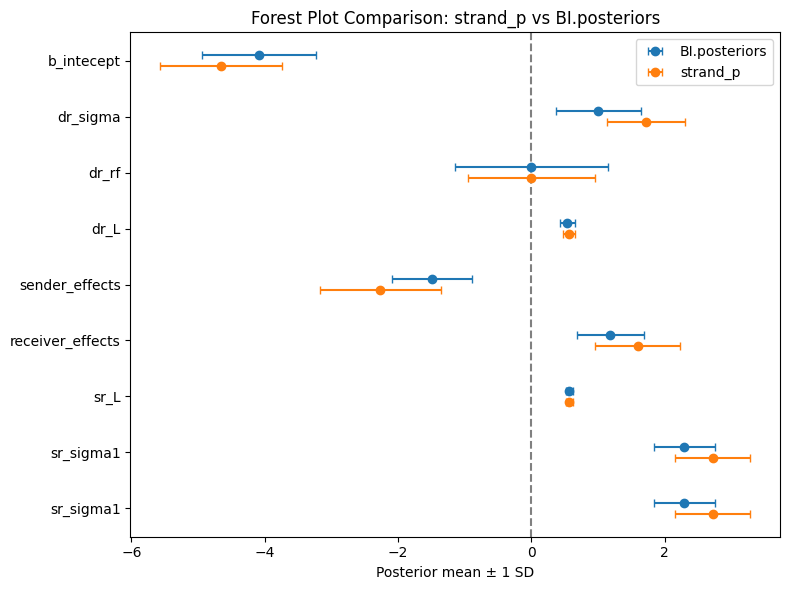

In [52]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter


strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = strand_to_dict(strand_posteriors)
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

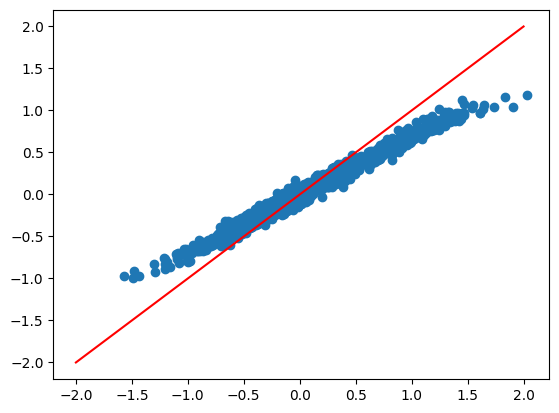

In [93]:
import matplotlib.pyplot as plt
m_dyads_random_effect_STRAND = strand_posteriors['dyadic_random_effects'].mean(axis=0)
m_dyads_random_effect_STRAND = m.net.mat_to_edgl(m_dyads_random_effect_STRAND)
m_dyads_random_effect_BI = m.posteriors['dr_raw'].mean(axis=0).T
plt.scatter(x=m_dyads_random_effect_STRAND, y=m_dyads_random_effect_BI)
x = np.linspace(-2, 2, 100)
y = x  # Diagonal: y = x
plt.plot(x, y, label='Diagonal Line', color='red')

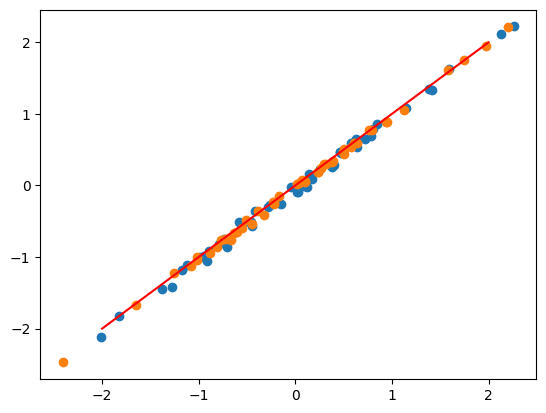

In [94]:
import matplotlib.pyplot as plt
m_focal_random_effect_STRAND = strand_posteriors['focal_target_random_effects'].mean(axis=0)
m_focal_random_effect_BI = m.posteriors['sr_raw'].mean(axis=0).T
plt.scatter(x=m_focal_random_effect_BI[:,0], y=m_focal_random_effect_STRAND[:,0])
plt.scatter(x=m_focal_random_effect_BI[:,1], y=m_focal_random_effect_STRAND[:,1])
x = np.linspace(-2, 2, 100)
y = x  # Diagonal: y = x
plt.plot(x, y, label='Diagonal Line', color='red')

### Sender receiver & dyadic effects model

#### Method accuracy demonstration.

In [100]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [101]:
%%R 
library(STRAND)
dr_raw = matrix(0, ncol = 3, nrow = 3)
dr_raw[1,] = c(0, 0.6, 0.66)
dr_raw[2,] = c(0.1, 0, 0.9)
dr_raw[3,] = c(-0.5, 0.24, 0)
tl = lower.tri(dr_raw, diag = FALSE)
tu = upper.tri(dr_raw, diag = FALSE)
dr2 = cbind(dr_raw[tl], dr_raw[tu])
d.sigma = c(0.2,0.2)

Rho = matrix(1, ncol = 2, nrow = 2)
rho = 0.73
Rho[1,2] = rho
Rho[2,1] = rho
L = chol(Rho)

R = NULL
for( a in 1:nrow(dr2)){
  R[[a]] = (L %*% dr2[a,]) * d.sigma
}
R


[[1]]
           [,1]
[1,] 0.10760000
[2,] 0.08201366
           [,1]
[1,] 0.10760000
[2,] 0.08201366

[[2]]
            [,1]
[1,] -0.00364000
[2,]  0.09021502

[[3]]
          [,1]
[1,] 0.1794000
[2,] 0.1230205



In [102]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
L = jnp.array(ro.globalenv['L']).reshape(2,2)
dr2 = jnp.array(ro.globalenv['dr2']).reshape(3,2).T
d_sigma = jnp.array(ro.globalenv['d.sigma'])
(L @ dr2).T * d_sigma

Array([[ 0.1076    ,  0.08201366],
       [-0.00364   ,  0.09021502],
       [ 0.1794    ,  0.12302049]], dtype=float64)

Code used in function is:

In [103]:
dr_raw =  m.dist.normal(0, 1, shape=(2, 3), name = 'dr_raw', sample = True)
dr_sigma = m.dist.exponential(1, shape=(1,), name = 'dr_sigma', sample = True )
dr_L = m.dist.lkj_cholesky(2, 2, name = 'dr_L', sample = True)
rf = ((dr_L @ dr_raw).T * jnp.repeat(dr_sigma, 2))
rf

Array([[-0.11158096,  0.13835452],
       [-0.42539842,  0.21275884],
       [ 0.98444711, -0.58399327]], dtype=float64)

#### Simulated data

In [37]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0  
dr_sigma = 1.5
dr_rho= 0.6

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1                         
                         )        
                         
################################################### Organize for model fitting
colnames(G$network)=rownames(G$network)=1:N_id
colnames(Kinship)=rownames(Kinship)=1:N_id
colnames(G$network)=rownames(G$network)=1:N_id
Kinship= matrix(Kinship,ncol=N_id, nrow= N_id)
Kinship= matrix(standardize(Kinship),ncol=N_id, nrow= N_id)
colnames(Kinship)=rownames(Kinship)=1:N_id

model_dat = make_strand_data(outcome=list("Assoc"=G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              dyadic_covariates=list(Kinship=Kinship),
                              outcome_mode = "bernoulli", 
                              link_mode="logit")


# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dyad.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 208.2 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.809" "1.897"   "4"      
[2,] "focal effects coeffs (out-degree), Mass" "2.468" "1.22"    "4.195"  
     Mean    SD      P      
[1,] "2.911" "0.716" "0"    
[2,] "2.54"  "0.923" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.557" "1.642"   "3.674"  
[2,] "target effects coeffs (in-degree), Mass" "1.31"  "-0.087"  "2.51"   
     Mean    SD      P      
[1,] "2.633" "0.658" "0"    
[2,] "1.354" "0.813" "0.038"

$`Dyadic effects`
     Variable                       

Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2, standardize

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpTKwxgX/

#### Send simulation to python

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
res = summarize_strand_results(fit)
strand_posteriors = res$samples$srm_model_samples

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.809" "1.897"   "4"      
[2,] "focal effects coeffs (out-degree), Mass" "2.468" "1.22"    "4.195"  
     Mean    SD     
[1,] "2.911" "0.716"
[2,] "2.54"  "0.923"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.557" "1.642"   "3.674"  
[2,] "target effects coeffs (in-degree), Mass" "1.31"  "-0.087"  "2.51"   
     Mean    SD     
[1,] "2.633" "0.658"
[2,] "1.354" "0.813"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "2.636" "1.36"    "4.171"   "2.757"
[2,] "dyadic effects coeffs, Kinship" "0.4"   "0.119"   "0.736"   "0.423"
     SD     
[1,] "0.928"
[2,] "0.201"

$`Other estimates`
     Variable                                            Median  

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [4]:
from BI import bi
import jax.numpy as jnp
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'].reshape(data['N_id'][0],data['N_id'][0]).T
exposure = data['exposure'].reshape(data['N_id'][0],data['N_id'][0]).T

def model(result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors):
    N_id = focal_individual_predictors.shape[0]
    # Block ---------------------------------------
    B=m.net.block_model(
        group = jnp.full(N_id,0),
        N_by_group = N_id, 
        N_group = 1, 
        name='intecept'
    )

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(
        focal_individual_predictors,
        target_individual_predictors,
    )

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(
        dyadic_predictors,
        dr_sigma_sd=2.5
    )

    m.dist.binomial(total_count = 1, logits = B + sr + dr, obs=result_outcomes)

m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = m.net.prepare_dyadic_effect(kinship), # Can be a jax array of multiple dimensions
    focal_individual_predictors = data['individual_predictors'].T,
    target_individual_predictors = data['individual_predictors'].T
)

m.fit(model, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
summary=m.summary()
summary[summary.index.str.contains('dyad_effects|receiver_effects|sender_effects|b_intecept')]


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:08<00:00, 113.84it/s, 127 steps of size 4.46e-02. acc. prob=0.92]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/3.12venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/3.12venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b_intecept[0, 0]",-5.50,1.41,-7.59,-3.15,0.31,0.11,18.53,37.08,NaN
dyad_effects[0],0.42,0.21,0.12,0.78,0.03,0.01,60.96,130.89,NaN
receiver_effects[0],1.46,0.70,0.36,2.47,0.05,0.03,203.51,399.55,NaN
sender_effects[0],2.64,0.97,1.22,4.25,0.12,0.06,71.52,146.84,NaN


dict_keys(['sr_sigma', 'sr_L', 'receiver_effects', 'sender_effects', 'dr_L', 'dr_sigma', 'dyad_effects', 'dr_raw', 'b_intecept'])
dict_values(['focal_target_sd', 'focal_target_L', 'target_coeffs', 'focal_coeffs', 'dyadic_L', 'dyadic_sd', 'dyadic_coeffs', 'dyadic_random_effects', 'block_parameters'])


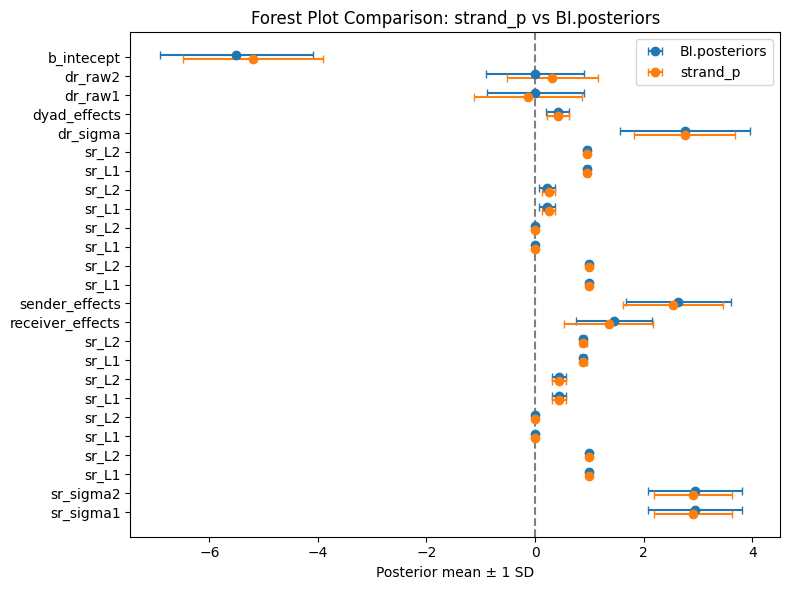

In [10]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from jax import vmap

strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = strand_to_dict(strand_posteriors)
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

In [ ]:
m.posteriors['dr_raw'].mean(axis=0).shape

(2, 1225)

In [ ]:
m.posteriors.keys()

dict_keys(['b_intecept', 'dr_L', 'dr_raw', 'dr_rf', 'dr_sigma', 'dyad_effects', 'receiver_effects', 'sender_effects', 'sr_L', 'sr_raw', 'sr_rf', 'sr_sigma'])

In [ ]:
strand_posteriors['dyadic_random_effects'].mean(axis = 0).shape

(50, 50)

In [ ]:
m.net.mat_to_edgl(strand_posteriors['dyadic_random_effects'].mean(axis = 0))

Array([[-0.2229598 , -0.02602509],
       [-0.14624552,  0.78281159],
       [ 1.10443135,  1.40023775],
       ...,
       [-0.06091964, -0.07478016],
       [-0.3498783 ,  0.45643419],
       [-0.18229988, -0.46487311]], dtype=float64)

In [ ]:
strand_posteriors.keys()

dict_keys(['block_parameters', 'focal_target_sd', 'focal_target_L', 'focal_target_random_effects', 'dyadic_sd', 'dyadic_L', 'dyadic_random_effects', 'focal_coeffs', 'target_coeffs', 'dyadic_coeffs'])

## Full model with new version of STRAND

### STRAND

In [2]:
%load_ext rpy2.ipython


In [3]:
%%R
library(rethinking)
library(igraph)
library(STRAND)
library(ggplot2)

set.seed(1)
# Make data
N_id = 100

# Covariates
Kinship = STRAND::standardize(rlkjcorr( 1 , N_id , eta=1.5 ))
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,3))

dyadic_preds[,,1] = Kinship
dyadic_preds[,,2] = Dominant
dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.8
sr_effects_1 = c(0, 0)
dr_effects_1 = c(0, 0, 0)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))
individual = data.frame(Mass=Mass)
groups_f

    Intercept Merica Quantum
1         Any  White Strange
2         Any   Blue Strange
3         Any  White   Charm
4         Any    Red   Charm
5         Any    Red Strange
6         Any    Red Strange
7         Any    Red Strange
8         Any    Red Strange
9         Any    Red   Charm
10        Any    Red Strange
11        Any   Blue   Charm
12        Any    Red   Charm
13        Any  White   Charm
14        Any    Red   Charm
15        Any  White   Charm
16        Any  White Strange
17        Any    Red Strange
18        Any   Blue Strange
19        Any   Blue   Charm
20        Any   Blue Strange
21        Any    Red Strange
22        Any    Red   Charm
23        Any   Blue   Charm
24        Any   Blue   Charm
25        Any  White   Charm
26        Any   Blue Strange
27        Any    Red Strange
28        Any  White   Charm
29        Any    Red Strange
30        Any   Blue Strange
31        Any   Blue Strange
32        Any   Blue Strange
33        Any    Red Strange
34        Any 

Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following object is masked from ‘package:stats’:

    rstudent


Attaching package: ‘igraph’

The following objects are masked from ‘package:rethinking’:

    compare, normalize

The following object is masked from ‘package:posterior’:

    E

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

STRAND: Social network analysis and simulation in R using Sta

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   2 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   3 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   4 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   5 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   6 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   7 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   8 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   9 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:  10 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  11 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  12 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  13 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  14 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  15 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  16 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  17 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  18 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  19 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  20 / 1000 [  2%]  (Warmup) 
Chain 1 It

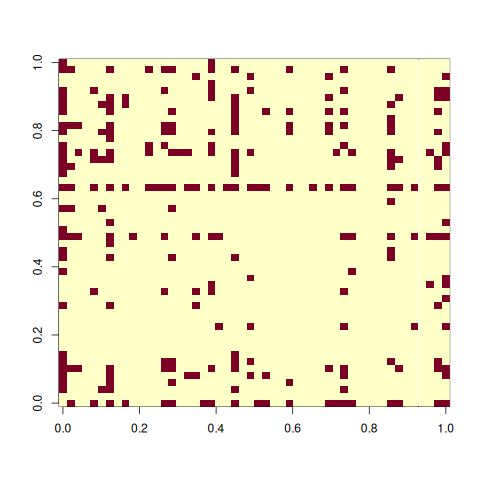

RInterpreterError: Failed to parse and evaluate line 'options(max.print = 100)\nlibrary(STRAND)\n\n\n\nfit_block_plus_social_relations_model_with_BI = function(data,\n                                    block_regression,\n                                    focal_regression,\n                                    target_regression,\n                                    dyad_regression,\n                                    mode="mcmc",\n                                    return_predicted_network=FALSE,\n                                    stan_mcmc_parameters = list(seed = 1, chains = 1, parallel_chains = 1, refresh = 1, iter_warmup = NULL,\n                                                                iter_sampling = NULL, max_treedepth = NULL, adapt_delta = NULL, init = NULL),\n                                    priors=NULL\n                                    )\n{\n\n    ############################################################################# Check inputs\n    if(attributes(data)$class != "STRAND Data Object"){\n        stop("fit_block_plus_social_relations_model() requires a data object of class: STRAND Data Object. Please use make_strand_data() to build your data list.")\n    }\n\n    if(!("SRM+SBM" %in% attributes(data)$supported_models)){\n        stop("The supplied data are not appropriate for a block plus social relations model. Please ensure that self_report data are single sampled and a group variable is provided.")\n    }\n\n    if(data$N_individual_predictors==0 & focal_regression != ~ 1){\n        stop("No individual covariate data has been provided. focal_regression must equal ~ 1 ")\n    }\n\n    if(data$N_individual_predictors==0 & target_regression != ~ 1){\n        stop("No individual covariate data has been provided. target_regression must equal ~ 1 ")\n    }\n\n    if(data$N_dyadic_predictors==0 & dyad_regression != ~ 1){\n        stop("No individual covariate data has been provided. dyad_regression must equal ~ 1 ")\n    }\n\n    if(data$N_block_predictors==0 & block_regression != ~ 1){\n        stop("No block covariate data has been provided. block_regression must equal ~ 1 ")\n    }\n\n    if(attributes(data)$directed == "undirected" & (focal_regression != target_regression) ){\n        warning("You have an undirected outcome, but focal_regression and target_regression are not equal.\n        In undirected models, these should be the same. Rethink your model.")\n    }\n\n    ############################################################################# Prepare data and parse formulas\n     ind_names = colnames(data$individual_predictors)\n     dyad_names = names(data$dyadic_predictors)\n\n     ################################################################ Dyad model matrix\n     if(data$N_dyadic_predictors>0){\n     dyad_dims = c(data$N_id, data$N_id, length(dyad_names))\n\n     dyad_dat = list()\n     for(i in 1:dyad_dims[3]){\n      dyad_dat[[i]] = c(data$dyadic_predictors[[i]])\n     }\n\n     #dyad_dat = do.call(rbind.data.frame, dyad_dat)\n     dyad_dat = do.call(data.frame, dyad_dat)\n     colnames(dyad_dat) = dyad_names\n     dyad_model_matrix = model_matrix_strand(dyad_regression , dyad_dat, "dyad_regression")\n\n     dyad_dat_out = array(NA, c(dyad_dims[1], dyad_dims[2], ncol(dyad_model_matrix)))\n     for(i in 1:ncol(dyad_model_matrix)){\n      dyad_dat_out[,,i] = matrix(dyad_model_matrix[,i], nrow=dyad_dims[1], ncol=dyad_dims[2])\n     }\n\n     dimnames(dyad_dat_out)[[3]] = colnames(dyad_model_matrix)\n     data$dyad_set = dyad_dat_out\n     } else{\n      data$dyad_set = array(1, c(data$N_id, data$N_id, 1))\n     }\n\n     ################################################################ Individual model matrix\n     if(data$N_individual_predictors>0){\n      data$focal_set = model_matrix_strand(focal_regression, data$individual_predictors, "focal_regression")\n      data$target_set = model_matrix_strand(target_regression , data$individual_predictors, "target_regression")\n     } else{\n      data$focal_set = matrix(1,nrow=data$N_id, ncol=1)\n      data$target_set = matrix(1,nrow=data$N_id, ncol=1)\n     }\n\n    data$N_params = c(ncol(data$focal_set), ncol(data$target_set), dim(data$dyad_set)[3])\n\n    ################################################################ Block model matrix\n     if(data$N_block_predictors>0){\n      data$block_set = model_matrix_strand(block_regression , data$block_predictors, "block_regression")\n     } else{\n      data$block_set = as.array(matrix(1, nrow=data$N_id, ncol=1))\n      colnames(data$block_set) = "(Intercept)"\n     }\n\n     data$N_group_vars = ncol(data$block_set)\n     data$N_groups_per_var = rep(NA, data$N_group_vars)\n\n     for(i in 1:data$N_group_vars){\n      data$N_groups_per_var[i] = length(unique(data$block_set[,i]))\n     }\n\n     data$N_groups_per_var = as.array(data$N_groups_per_var)\n\n     data$max_N_groups = max(data$N_groups_per_var)\n\n    ############### Priors\n    data$export_network = ifelse(return_predicted_network==TRUE, 1, 0)\n\n    if(is.null(priors)){\n      data$priors =  make_priors()\n      } else{\n    data$priors = priors\n      }\n\n    ############################################################################# Fit model\n    if(mode != \'BI\'){\n      model = cmdstanr::cmdstan_model(paste0(path.package("STRAND"),"/","block_plus_social_relations_model.stan"))\n    }\n\n    data$individual_predictors = NULL\n    data$dyadic_predictors = NULL\n    data$block_predictors = NULL\n\n    if(mode=="mcmc"){\n      fit = model$sample(\n        data = unclass(data),\n        seed = stan_mcmc_parameters$seed,\n        chains = stan_mcmc_parameters$chain,\n        parallel_chains = stan_mcmc_parameters$parallel_chains,\n        refresh = stan_mcmc_parameters$refresh,\n        iter_warmup = stan_mcmc_parameters$iter_warmup,\n        iter_sampling = stan_mcmc_parameters$iter_sampling,\n        max_treedepth = stan_mcmc_parameters$max_treedepth,\n        adapt_delta = stan_mcmc_parameters$adapt_delta,\n        init = stan_mcmc_parameters$init\n        )\n       }\n\n    if(mode=="vb"){\n     print("Variational inference is fast, but not always dependable. We recommend using vb only for test runs.")\n     fit = model$pathfinder(data = unclass(data))\n     }\n\n    if(mode=="optim"){\n     print("Optimazation is fast, but not always dependable. We recommend using optim only for test runs.")\n     fit = model$optimize(data = unclass(data), seed = 123)\n     }\n\n    if(mode=="BI"){\n      print("The BI backend is a new option, we recommened cross-checking final model fits against Stan models fit with \'mcmc\'.")\n      fit = fit_with_BI(data, stan_mcmc_parameters)\n    }\n\n    if(! mode %in% c("mcmc", "vb", "optim", "BI") ){\n     stop("Must supply a legal mode value: mcmc, vb, optim, or BI.")\n    }\n\n    bob = list(data=data, fit=fit, return_predicted_network=return_predicted_network )\n    attr(bob, "class") = "STRAND Model Object"\n    attr(bob, "fit_type") = mode\n    attr(bob, "model_type") = "SRM+SBM"\n\n    return(bob)\n}\n\n\n\n\n convert_posterior = function(posteriors){\n  np = reticulate::import(\'numpy\')\n  R_list = reticulate::py_to_r(posteriors)\n  for(a in 1:length(R_list)){\n    R_list[[a]] = reticulate::py_to_r(np$array(R_list[[a]]))\n  }\n  return(R_list)\n}\n\n\n\nsummarize_bsrm_results = function(input, include_samples=TRUE, HPDI=0.9){\n    if(attributes(input)$class != "STRAND Model Object"){\n        stop("summarize_bsrm_results() requires a fitted object of class: STRAND Model Object. Please use fit_block_plus_social_relations_model() to run your model.")\n    }\n\n    ###################################################### Create samples \n    outcome_mode = input$data$outcome_mode \n\n    if(attr(input, "fit_type")=="BI"){\n        BI = TRUE\n    }else{\n        BI = FALSE\n            if(attributes(input)$fit_type != "mcmc"){\n            if(attributes(input)$fit_type == "vb"){\n         warning("Final, publication-ready model fits for STRAND models should always be produced using MCMC! Variational inference via Pathfinder can be used in Stan\n              during experimental model runs, but final inferences should be based on MCMC sampling. In our tests, Pathfinder results are decently similar to MCMC results, \n              but often failed to recover strong true effects. ")  \n         } else{\n         stop("Fitted results can only be reorganized for STRAND model objects fit using MCMC. Variational inference or optimization can be used in Stan\n              during experimental model runs, but final inferences should be based on MCMC sampling.")  \n      }    \n     }\n    }\n\n    ################### Network model parameters\n      if(BI==FALSE){\n    stanfit = posterior::as_draws_rvars(input$fit$draws())\n\n    sr_sigma = posterior::draws_of(stanfit$"sr_sigma")\n    sr_L = posterior::draws_of(stanfit$"sr_L") \n    sr_raw = posterior::draws_of(stanfit$"sr_raw")\n\n    dr_L = posterior::draws_of(stanfit$"dr_L")\n    dr_raw = posterior::draws_of(stanfit$"dr_raw") \n    dr_sigma = posterior::draws_of(stanfit$"dr_sigma")\n\n    error_sigma = posterior::draws_of(stanfit$"error_sigma")\n\n    if(dim(input$data$block_set)[2]>0)\n    block_effects = posterior::draws_of(stanfit$"block_effects")\n\n    if(dim(input$data$focal_set)[2]>1)\n    focal_effects = posterior::draws_of(stanfit$"focal_effects") \n\n    if(dim(input$data$target_set)[2]>1)\n    target_effects = posterior::draws_of(stanfit$"target_effects")  \n\n    if(dim(input$data$dyad_set)[3]>1)\n    dyad_effects = posterior::draws_of(stanfit$"dyad_effects")\n      }\n\n    ################### Network model parameters BI\n    if(BI==TRUE){\n    samps = convert_posterior(input$fit$posteriors)\n\n    sr_sigma = samps$sr_sigma\n    sr_L = samps$sr_L \n    sr_raw = aperm(samps$sr_raw, perm = c(1, 3, 2))\n\n    dr_L = samps$dr_L \n    dr_raw = samps$dr_raw\n    dr_sigma = samps$dr_sigma\n\n    error_sigma = dr_sigma     \n    for(i in 1:dim(error_sigma)[1]) \n    error_sigma[i,1] = NA      \n\n    if(dim(input$data$block_set)[2]>0)\n    block_effects = samps$block_effects\n\n    if(dim(input$data$focal_set)[2]>1){\n      focal_effects = samps$focal_effects\n      focal_effects = focal_effects[, -1, drop = FALSE]\n    }\n\n    if(dim(input$data$target_set)[2]>1){\n      target_effects = samps$target_effects\n      target_effects = target_effects[, -1, drop = FALSE]\n    }\n\n\n    if(dim(input$data$dyad_set)[3]>1){\n      dyad_effects = samps$dyad_effects\n      dyad_effects = dyad_effects[, -1, drop = FALSE]\n    }\n\n      }\n\n    ################### Get index data for block-model samples\n    block_indexes = c()\n    block_indexes[1] = 0\n    for(q in 1:input$data$N_group_vars){ \n    block_indexes[1+q] = input$data$N_groups_per_var[q]*input$data$N_groups_per_var[q] + block_indexes[q]\n    }\n\n    ################### Convert the block-model effects into an array form\n    B = list()\n    for(q in 1:input$data$N_group_vars){\n      B[[q]] = array(NA, c(dim(block_effects)[1], input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]  ))\n\n      for(s in 1:dim(block_effects)[1]){\n       B[[q]][s,,] =  array(block_effects[s,(block_indexes[q]+1):(block_indexes[q+1])], c(input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]))\n      }\n    }   \n\n    srm_samples = list(\n            block_parameters=B,\n\n            focal_target_sd=sr_sigma,\n            focal_target_L=sr_L,\n            focal_target_random_effects=sr_raw,\n\n            dyadic_sd = dr_sigma,\n            dyadic_L = dr_L,\n            dyadic_random_effects=dr_raw,\n            error_sd = error_sigma\n        )\n\n    if(dim(input$data$focal_set)[2]>1)\n    srm_samples$focal_coeffs = focal_effects\n\n    if(dim(input$data$target_set)[2]>1)\n    srm_samples$target_coeffs = target_effects\n\n    if(dim(input$data$dyad_set)[3]>1)\n    srm_samples$dyadic_coeffs = dyad_effects\n\n    samples = list(srm_model_samples=srm_samples)\n\n    if(BI==FALSE){\n      if(input$return_predicted_network == TRUE){\n        samples$predicted_network_sample = posterior::draws_of(stanfit$"p")\n        }\n    }    \n\n    ###################################################### Create summary stats \n     results_list = list()\n\n    ################### SRM model\n     Q1 = dim(input$data$focal_set)[2]-1\n     Q2 = dim(input$data$target_set)[2]-1\n     Q3 = dim(input$data$dyad_set)[3]-1\n\n     results_srm_focal = matrix(NA, nrow=(1+Q1) , ncol=7)\n     results_srm_target = matrix(NA, nrow=(1+Q2) , ncol=7)\n     results_srm_dyadic = matrix(NA, nrow=(1+Q3) , ncol=7)\n\n    ######### Calculate all focal effects\n     results_srm_focal[1,] = sum_stats("focal effects sd", samples$srm_model_samples$focal_target_sd[,1], HPDI)\n     if(Q1>0){\n     coeff_names = colnames(input$data$focal_set)[-1]\n        for(i in 1:Q1){\n     results_srm_focal[1+i,] = sum_stats(paste0("focal effects coeffs (out-degree), ", coeff_names[i] ), samples$srm_model_samples$focal_coeffs[,i], HPDI)\n        }\n      }\n\n      results_list[[1]] = results_srm_focal\n\n    ######### Calculate all target effects\n     results_srm_target[1,] = sum_stats("target effects sd", samples$srm_model_samples$focal_target_sd[,2], HPDI)\n     if(Q2>0){\n     coeff_names = colnames(input$data$target_set)[-1]\n        for(i in 1:Q2){\n     results_srm_target[1+i,] = sum_stats(paste0("target effects coeffs (in-degree), ", coeff_names[i] ), samples$srm_model_samples$target_coeffs[,i], HPDI)\n        }\n      }\n\n      results_list[[2]] = results_srm_target\n\n    ######### Calculate all dyad effects\n     results_srm_dyadic[1,] = sum_stats("dyadic effects sd", c(samples$srm_model_samples$dyadic_sd), HPDI)\n     if(Q3>0){\n     coeff_names = dimnames(input$data$dyad_set)[[3]][-1]\n        for(i in 1:Q3){\n     results_srm_dyadic[1+i,] = sum_stats(paste0("dyadic effects coeffs, ", coeff_names[i] ), samples$srm_model_samples$dyadic_coeffs[,i], HPDI)\n        }\n      }\n     results_list[[3]] = results_srm_dyadic\n\n    ######### Calculate all block effects\n     results_srm_base = matrix(NA, nrow=3 + dim(block_effects)[2], ncol=7)\n     results_srm_base[1,] = sum_stats("focal-target effects rho (generalized recipocity)", samples$srm_model_samples$focal_target_L[,2,1], HPDI)\n     results_srm_base[2,] = sum_stats("dyadic effects rho (dyadic recipocity)", samples$srm_model_samples$dyadic_L[,2,1], HPDI)\n\n        if(outcome_mode == 4){\n        results_srm_base[3,] = sum_stats("error sd", c(samples$srm_model_samples$error_sd), HPDI)\n        } else{\n        results_srm_base[3,] = c("error sd", rep(NA,6))     \n        }\n\n\n     group_ids_character_df = cbind(rep("Any",input$data$N_id),attr(input$data, "group_ids_character"))\n\n     if(is.null(colnames(group_ids_character_df))){\n        colnames(group_ids_character_df) = paste0("(NoBlockingVars)", 1:ncol(group_ids_character_df))\n     }\n\n     colnames(group_ids_character_df)[1] = "(Intercept)"\n\n     in_IDs = colnames(input$data$block_set)\n     all_IDs = colnames(group_ids_character_df)\n     group_ids_character_df = group_ids_character_df[,match(in_IDs, all_IDs), drop = FALSE]\n\n     group_id_levels = append("Any", attr(input$data, "group_ids_levels"), 1)\n     names(group_id_levels)[1]= "(Intercept)"\n\n     ticker = 0\n     for(q in 1:input$data$N_group_vars){\n      group_ids_character = levels(factor(group_ids_character_df[,q]))\n      test_sorting = group_id_levels[[which(names(group_id_levels) == colnames(group_ids_character_df)[q])]]\n      if(all(group_ids_character==test_sorting)==FALSE){\n        stop("Factors not sorted correctly.")\n      }\n\n      for(b1 in 1:input$data$N_groups_per_var[q]){\n      for(b2 in 1:input$data$N_groups_per_var[q]){\n       ticker = ticker + 1  \n      results_srm_base[ 3 + ticker,] = sum_stats(paste0("offset, ", group_ids_character[b1], " to ", group_ids_character[b2]), \n                                                                         samples$srm_model_samples$block_parameters[[q]][,b1,b2], HPDI)\n     }}\n\n     }\n\n     results_list[[4]] = results_srm_base\n\n   ############# Finally, merge all effects into a list\n     for(i in 1:4)\n     colnames(results_list[[i]]) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") \n\n     names(results_list) = c( "Focal effects: Out-degree", "Target effects: In-degree", "Dyadic effects", "Other estimates")\n\n   results_out = rbind( results_srm_focal, results_srm_target,results_srm_dyadic, results_srm_base)\n\n   df = data.frame(results_out)\n   colnames(df) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") \n\n   res_final = list(summary=df, summary_list=results_list)\n\n  if(include_samples==TRUE){\n    res_final$samples=samples\n   }\n\n   print(results_list)\n\n    attr(res_final, "class") = "STRAND Results Object"\n    return(res_final)\n}\n\n\n############################ Test models \n# Load libraries\nlibrary(rethinking)\nlibrary(igraph)\nlibrary(STRAND)\nlibrary(ggplot2)\n\nset.seed(1)\n# Make data\nN_id = 50\n\n# Covariates\nKinship = STRAND::standardize(rlkjcorr( 1 , N_id , eta=1.5 ))\nDominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)\nMass = rbern(N_id, 0.4)\n\n# Organize into list\ndyadic_preds = array(NA,c(N_id,N_id,3))\n\ndyadic_preds[,,1] = Kinship\ndyadic_preds[,,2] = Dominant\ndyadic_preds[,,3] = Kinship*Dominant\n\n# Set effect sizes\nsr_mu = c(0,0)  \nsr_sigma = c(2.2, 1.7) \nsr_rho = 0\ndr_mu = 0 \ndr_sigma = 1.5\ndr_rho= 0.8\nsr_effects_1 = c(0, 0)\ndr_effects_1 = c(0, 0, 0)\n\n# Block structure\ngroup_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))\n\nB_1 = matrix(-10,nrow=1,ncol=1)\nB_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)\nB_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)\n\ndiag(B_2) = diag(B_2) + 2\ndiag(B_3) = diag(B_3) + 3.5\n\nB=list(B_1, B_2, B_3)\n\ngroups_1 = rep("Any",N_id) \ngroups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )\ngroups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )\n\ngroups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))\ngroups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))\nindividual = data.frame(Mass=Mass)\n\n\n#################################################### Simulate SBM + SRM network\nG = simulate_sbm_plus_srm_network(N_id = N_id, \n                         B = B, \n                         V=3,\n                         groups=groups,                  \n                         sr_mu = sr_mu,  \n                         sr_sigma = sr_sigma, \n                         sr_rho = sr_rho,\n                         dr_mu = dr_mu,  \n                         dr_sigma = dr_sigma, \n                         dr_rho = dr_rho,\n                         error_sigma = 1.0,\n                         outcome_mode="bernoulli", \n                         link_mode="logit",                 \n                         individual_predictors = data.frame(Mass=Mass),\n                         dyadic_predictors = dyadic_preds,\n                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),\n                         dyadic_effects = dr_effects_1\n                         )      \n\nimage(G$network)\n\n################################################################################################ Fit STRAND\n# Create the STRAND data object\n# Add row and colnames\nname_vec = paste("Individual", 1:N_id)\nrownames(G$network) = colnames(G$network) = name_vec\nrownames(G$samps) = colnames(G$samps) = name_vec\nrownames(Kinship) = colnames(Kinship) = name_vec\nrownames(Dominant) = colnames(Dominant) = name_vec\nrownames(groups_f) = name_vec\nrownames(individual) = name_vec\n\nmodel_dat = make_strand_data(outcome=list(Association = G$network),  \n                             block_covariates=groups_f, \n                             individual_covariates=individual, \n                             dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),\n                             outcome_mode="bernoulli", \n                             link_mode="logit"\n                             )\n\nfit1 = fit_block_plus_social_relations_model_with_BI(\n    data=model_dat,\n    block_regression = ~ Merica + Quantum,\n    focal_regression = ~ Mass,\n    target_regression = ~ Mass,\n    dyad_regression = ~ Kinship + Dominant + Kinship * Dominant,\n    mode="mcmc",\n    stan_mcmc_parameters = list(\n      chains = 1,\n      iter_warmup = 500 ,\n      iter_sampling = 500 ,\n      max_treedepth = 12 ,\n      refresh = 1,\n      adapt_delta = 0.96)\n  )\n\nres1 = summarize_bsrm_results(fit1)\n'.
R error message: "cannot start processx process 'wsl' (system error 2, No such file or directory) @unix/processx.c:611 (processx_exec)"
R stdout:
Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpV2mVwE/model-29f01f6ef83d.stan', line 147, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpV2mVwE/model-29f01f6ef83d.stan', line 147, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpV2mVwE/model-29f01f6ef83d.stan', line 147, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1

In [4]:
%%R
options(max.print = 100)
library(STRAND)



fit_block_plus_social_relations_model_with_BI = function(data,
                                    block_regression,
                                    focal_regression,
                                    target_regression,
                                    dyad_regression,
                                    mode="mcmc",
                                    return_predicted_network=FALSE,
                                    stan_mcmc_parameters = list(seed = 1, chains = 1, parallel_chains = 1, refresh = 1, iter_warmup = NULL,
                                                                iter_sampling = NULL, max_treedepth = NULL, adapt_delta = NULL, init = NULL),
                                    priors=NULL
                                    )
{

    ############################################################################# Check inputs
    if(attributes(data)$class != "STRAND Data Object"){
        stop("fit_block_plus_social_relations_model() requires a data object of class: STRAND Data Object. Please use make_strand_data() to build your data list.")
    }

    if(!("SRM+SBM" %in% attributes(data)$supported_models)){
        stop("The supplied data are not appropriate for a block plus social relations model. Please ensure that self_report data are single sampled and a group variable is provided.")
    }

    if(data$N_individual_predictors==0 & focal_regression != ~ 1){
        stop("No individual covariate data has been provided. focal_regression must equal ~ 1 ")
    }

    if(data$N_individual_predictors==0 & target_regression != ~ 1){
        stop("No individual covariate data has been provided. target_regression must equal ~ 1 ")
    }

    if(data$N_dyadic_predictors==0 & dyad_regression != ~ 1){
        stop("No individual covariate data has been provided. dyad_regression must equal ~ 1 ")
    }

    if(data$N_block_predictors==0 & block_regression != ~ 1){
        stop("No block covariate data has been provided. block_regression must equal ~ 1 ")
    }

    if(attributes(data)$directed == "undirected" & (focal_regression != target_regression) ){
        warning("You have an undirected outcome, but focal_regression and target_regression are not equal.
        In undirected models, these should be the same. Rethink your model.")
    }

    ############################################################################# Prepare data and parse formulas
     ind_names = colnames(data$individual_predictors)
     dyad_names = names(data$dyadic_predictors)

     ################################################################ Dyad model matrix
     if(data$N_dyadic_predictors>0){
     dyad_dims = c(data$N_id, data$N_id, length(dyad_names))

     dyad_dat = list()
     for(i in 1:dyad_dims[3]){
      dyad_dat[[i]] = c(data$dyadic_predictors[[i]])
     }

     #dyad_dat = do.call(rbind.data.frame, dyad_dat)
     dyad_dat = do.call(data.frame, dyad_dat)
     colnames(dyad_dat) = dyad_names
     dyad_model_matrix = model_matrix_strand(dyad_regression , dyad_dat, "dyad_regression")

     dyad_dat_out = array(NA, c(dyad_dims[1], dyad_dims[2], ncol(dyad_model_matrix)))
     for(i in 1:ncol(dyad_model_matrix)){
      dyad_dat_out[,,i] = matrix(dyad_model_matrix[,i], nrow=dyad_dims[1], ncol=dyad_dims[2])
     }

     dimnames(dyad_dat_out)[[3]] = colnames(dyad_model_matrix)
     data$dyad_set = dyad_dat_out
     } else{
      data$dyad_set = array(1, c(data$N_id, data$N_id, 1))
     }

     ################################################################ Individual model matrix
     if(data$N_individual_predictors>0){
      data$focal_set = model_matrix_strand(focal_regression, data$individual_predictors, "focal_regression")
      data$target_set = model_matrix_strand(target_regression , data$individual_predictors, "target_regression")
     } else{
      data$focal_set = matrix(1,nrow=data$N_id, ncol=1)
      data$target_set = matrix(1,nrow=data$N_id, ncol=1)
     }

    data$N_params = c(ncol(data$focal_set), ncol(data$target_set), dim(data$dyad_set)[3])

    ################################################################ Block model matrix
     if(data$N_block_predictors>0){
      data$block_set = model_matrix_strand(block_regression , data$block_predictors, "block_regression")
     } else{
      data$block_set = as.array(matrix(1, nrow=data$N_id, ncol=1))
      colnames(data$block_set) = "(Intercept)"
     }

     data$N_group_vars = ncol(data$block_set)
     data$N_groups_per_var = rep(NA, data$N_group_vars)

     for(i in 1:data$N_group_vars){
      data$N_groups_per_var[i] = length(unique(data$block_set[,i]))
     }

     data$N_groups_per_var = as.array(data$N_groups_per_var)

     data$max_N_groups = max(data$N_groups_per_var)

    ############### Priors
    data$export_network = ifelse(return_predicted_network==TRUE, 1, 0)

    if(is.null(priors)){
      data$priors =  make_priors()
      } else{
    data$priors = priors
      }

    ############################################################################# Fit model
    if(mode != 'BI'){
      model = cmdstanr::cmdstan_model(paste0(path.package("STRAND"),"/","block_plus_social_relations_model.stan"))
    }

    data$individual_predictors = NULL
    data$dyadic_predictors = NULL
    data$block_predictors = NULL

    if(mode=="mcmc"){
      fit = model$sample(
        data = unclass(data),
        seed = stan_mcmc_parameters$seed,
        chains = stan_mcmc_parameters$chain,
        parallel_chains = stan_mcmc_parameters$parallel_chains,
        refresh = stan_mcmc_parameters$refresh,
        iter_warmup = stan_mcmc_parameters$iter_warmup,
        iter_sampling = stan_mcmc_parameters$iter_sampling,
        max_treedepth = stan_mcmc_parameters$max_treedepth,
        adapt_delta = stan_mcmc_parameters$adapt_delta,
        init = stan_mcmc_parameters$init
        )
       }

    if(mode=="vb"){
     print("Variational inference is fast, but not always dependable. We recommend using vb only for test runs.")
     fit = model$pathfinder(data = unclass(data))
     }

    if(mode=="optim"){
     print("Optimazation is fast, but not always dependable. We recommend using optim only for test runs.")
     fit = model$optimize(data = unclass(data), seed = 123)
     }

    if(mode=="BI"){
      print("The BI backend is a new option, we recommened cross-checking final model fits against Stan models fit with 'mcmc'.")
      fit = fit_with_BI(data, stan_mcmc_parameters)
    }

    if(! mode %in% c("mcmc", "vb", "optim", "BI") ){
     stop("Must supply a legal mode value: mcmc, vb, optim, or BI.")
    }

    bob = list(data=data, fit=fit, return_predicted_network=return_predicted_network )
    attr(bob, "class") = "STRAND Model Object"
    attr(bob, "fit_type") = mode
    attr(bob, "model_type") = "SRM+SBM"

    return(bob)
}




 convert_posterior = function(posteriors){
  np = reticulate::import('numpy')
  R_list = reticulate::py_to_r(posteriors)
  for(a in 1:length(R_list)){
    R_list[[a]] = reticulate::py_to_r(np$array(R_list[[a]]))
  }
  return(R_list)
}



summarize_bsrm_results = function(input, include_samples=TRUE, HPDI=0.9){
    if(attributes(input)$class != "STRAND Model Object"){
        stop("summarize_bsrm_results() requires a fitted object of class: STRAND Model Object. Please use fit_block_plus_social_relations_model() to run your model.")
    }

    ###################################################### Create samples 
    outcome_mode = input$data$outcome_mode 

    if(attr(input, "fit_type")=="BI"){
        BI = TRUE
    }else{
        BI = FALSE
            if(attributes(input)$fit_type != "mcmc"){
            if(attributes(input)$fit_type == "vb"){
         warning("Final, publication-ready model fits for STRAND models should always be produced using MCMC! Variational inference via Pathfinder can be used in Stan
              during experimental model runs, but final inferences should be based on MCMC sampling. In our tests, Pathfinder results are decently similar to MCMC results, 
              but often failed to recover strong true effects. ")  
         } else{
         stop("Fitted results can only be reorganized for STRAND model objects fit using MCMC. Variational inference or optimization can be used in Stan
              during experimental model runs, but final inferences should be based on MCMC sampling.")  
      }    
     }
    }

    ################### Network model parameters
      if(BI==FALSE){
    stanfit = posterior::as_draws_rvars(input$fit$draws())

    sr_sigma = posterior::draws_of(stanfit$"sr_sigma")
    sr_L = posterior::draws_of(stanfit$"sr_L") 
    sr_raw = posterior::draws_of(stanfit$"sr_raw")

    dr_L = posterior::draws_of(stanfit$"dr_L")
    dr_raw = posterior::draws_of(stanfit$"dr_raw") 
    dr_sigma = posterior::draws_of(stanfit$"dr_sigma")

    error_sigma = posterior::draws_of(stanfit$"error_sigma")
    
    if(dim(input$data$block_set)[2]>0)
    block_effects = posterior::draws_of(stanfit$"block_effects")

    if(dim(input$data$focal_set)[2]>1)
    focal_effects = posterior::draws_of(stanfit$"focal_effects") 

    if(dim(input$data$target_set)[2]>1)
    target_effects = posterior::draws_of(stanfit$"target_effects")  

    if(dim(input$data$dyad_set)[3]>1)
    dyad_effects = posterior::draws_of(stanfit$"dyad_effects")
      }

    ################### Network model parameters BI
    if(BI==TRUE){
    samps = convert_posterior(input$fit$posteriors)

    sr_sigma = samps$sr_sigma
    sr_L = samps$sr_L 
    sr_raw = aperm(samps$sr_raw, perm = c(1, 3, 2))

    dr_L = samps$dr_L 
    dr_raw = samps$dr_raw
    dr_sigma = samps$dr_sigma

    error_sigma = dr_sigma     
    for(i in 1:dim(error_sigma)[1]) 
    error_sigma[i,1] = NA      
    
    if(dim(input$data$block_set)[2]>0)
    block_effects = samps$block_effects

    if(dim(input$data$focal_set)[2]>1){
      focal_effects = samps$focal_effects
      focal_effects = focal_effects[, -1, drop = FALSE]
    }

    if(dim(input$data$target_set)[2]>1){
      target_effects = samps$target_effects
      target_effects = target_effects[, -1, drop = FALSE]
    }


    if(dim(input$data$dyad_set)[3]>1){
      dyad_effects = samps$dyad_effects
      dyad_effects = dyad_effects[, -1, drop = FALSE]
    }
    
      }

    ################### Get index data for block-model samples
    block_indexes = c()
    block_indexes[1] = 0
    for(q in 1:input$data$N_group_vars){ 
    block_indexes[1+q] = input$data$N_groups_per_var[q]*input$data$N_groups_per_var[q] + block_indexes[q]
    }

    ################### Convert the block-model effects into an array form
    B = list()
    for(q in 1:input$data$N_group_vars){
      B[[q]] = array(NA, c(dim(block_effects)[1], input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]  ))

      for(s in 1:dim(block_effects)[1]){
       B[[q]][s,,] =  array(block_effects[s,(block_indexes[q]+1):(block_indexes[q+1])], c(input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]))
      }
    }   

    srm_samples = list(
            block_parameters=B,

            focal_target_sd=sr_sigma,
            focal_target_L=sr_L,
            focal_target_random_effects=sr_raw,

            dyadic_sd = dr_sigma,
            dyadic_L = dr_L,
            dyadic_random_effects=dr_raw,
            error_sd = error_sigma
        )

    if(dim(input$data$focal_set)[2]>1)
    srm_samples$focal_coeffs = focal_effects

    if(dim(input$data$target_set)[2]>1)
    srm_samples$target_coeffs = target_effects

    if(dim(input$data$dyad_set)[3]>1)
    srm_samples$dyadic_coeffs = dyad_effects

    samples = list(srm_model_samples=srm_samples)

    if(BI==FALSE){
      if(input$return_predicted_network == TRUE){
        samples$predicted_network_sample = posterior::draws_of(stanfit$"p")
        }
    }    

    ###################################################### Create summary stats 
     results_list = list()

    ################### SRM model
     Q1 = dim(input$data$focal_set)[2]-1
     Q2 = dim(input$data$target_set)[2]-1
     Q3 = dim(input$data$dyad_set)[3]-1

     results_srm_focal = matrix(NA, nrow=(1+Q1) , ncol=7)
     results_srm_target = matrix(NA, nrow=(1+Q2) , ncol=7)
     results_srm_dyadic = matrix(NA, nrow=(1+Q3) , ncol=7)

    ######### Calculate all focal effects
     results_srm_focal[1,] = sum_stats("focal effects sd", samples$srm_model_samples$focal_target_sd[,1], HPDI)
     if(Q1>0){
     coeff_names = colnames(input$data$focal_set)[-1]
        for(i in 1:Q1){
     results_srm_focal[1+i,] = sum_stats(paste0("focal effects coeffs (out-degree), ", coeff_names[i] ), samples$srm_model_samples$focal_coeffs[,i], HPDI)
        }
      }

      results_list[[1]] = results_srm_focal

    ######### Calculate all target effects
     results_srm_target[1,] = sum_stats("target effects sd", samples$srm_model_samples$focal_target_sd[,2], HPDI)
     if(Q2>0){
     coeff_names = colnames(input$data$target_set)[-1]
        for(i in 1:Q2){
     results_srm_target[1+i,] = sum_stats(paste0("target effects coeffs (in-degree), ", coeff_names[i] ), samples$srm_model_samples$target_coeffs[,i], HPDI)
        }
      }

      results_list[[2]] = results_srm_target

    ######### Calculate all dyad effects
     results_srm_dyadic[1,] = sum_stats("dyadic effects sd", c(samples$srm_model_samples$dyadic_sd), HPDI)
     if(Q3>0){
     coeff_names = dimnames(input$data$dyad_set)[[3]][-1]
        for(i in 1:Q3){
     results_srm_dyadic[1+i,] = sum_stats(paste0("dyadic effects coeffs, ", coeff_names[i] ), samples$srm_model_samples$dyadic_coeffs[,i], HPDI)
        }
      }
     results_list[[3]] = results_srm_dyadic

    ######### Calculate all block effects
     results_srm_base = matrix(NA, nrow=3 + dim(block_effects)[2], ncol=7)
     results_srm_base[1,] = sum_stats("focal-target effects rho (generalized recipocity)", samples$srm_model_samples$focal_target_L[,2,1], HPDI)
     results_srm_base[2,] = sum_stats("dyadic effects rho (dyadic recipocity)", samples$srm_model_samples$dyadic_L[,2,1], HPDI)

        if(outcome_mode == 4){
        results_srm_base[3,] = sum_stats("error sd", c(samples$srm_model_samples$error_sd), HPDI)
        } else{
        results_srm_base[3,] = c("error sd", rep(NA,6))     
        }

 
     group_ids_character_df = cbind(rep("Any",input$data$N_id),attr(input$data, "group_ids_character"))

     if(is.null(colnames(group_ids_character_df))){
        colnames(group_ids_character_df) = paste0("(NoBlockingVars)", 1:ncol(group_ids_character_df))
     }
     
     colnames(group_ids_character_df)[1] = "(Intercept)"

     in_IDs = colnames(input$data$block_set)
     all_IDs = colnames(group_ids_character_df)
     group_ids_character_df = group_ids_character_df[,match(in_IDs, all_IDs), drop = FALSE]

     group_id_levels = append("Any", attr(input$data, "group_ids_levels"), 1)
     names(group_id_levels)[1]= "(Intercept)"
     
     ticker = 0
     for(q in 1:input$data$N_group_vars){
      group_ids_character = levels(factor(group_ids_character_df[,q]))
      test_sorting = group_id_levels[[which(names(group_id_levels) == colnames(group_ids_character_df)[q])]]
      if(all(group_ids_character==test_sorting)==FALSE){
        stop("Factors not sorted correctly.")
      }

      for(b1 in 1:input$data$N_groups_per_var[q]){
      for(b2 in 1:input$data$N_groups_per_var[q]){
       ticker = ticker + 1  
      results_srm_base[ 3 + ticker,] = sum_stats(paste0("offset, ", group_ids_character[b1], " to ", group_ids_character[b2]), 
                                                                         samples$srm_model_samples$block_parameters[[q]][,b1,b2], HPDI)
     }}

     }
     
     results_list[[4]] = results_srm_base

   ############# Finally, merge all effects into a list
     for(i in 1:4)
     colnames(results_list[[i]]) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") 

     names(results_list) = c( "Focal effects: Out-degree", "Target effects: In-degree", "Dyadic effects", "Other estimates")
          
   results_out = rbind( results_srm_focal, results_srm_target,results_srm_dyadic, results_srm_base)
   
   df = data.frame(results_out)
   colnames(df) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") 

   res_final = list(summary=df, summary_list=results_list)

  if(include_samples==TRUE){
    res_final$samples=samples
   }

   print(results_list)

    attr(res_final, "class") = "STRAND Results Object"
    return(res_final)
}


############################ Test models 
# Load libraries
library(rethinking)
library(igraph)
library(STRAND)
library(ggplot2)

set.seed(1)
# Make data
N_id = 50

# Covariates
Kinship = STRAND::standardize(rlkjcorr( 1 , N_id , eta=1.5 ))
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,3))

dyadic_preds[,,1] = Kinship
dyadic_preds[,,2] = Dominant
dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.8
sr_effects_1 = c(0, 0)
dr_effects_1 = c(0, 0, 0)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))
individual = data.frame(Mass=Mass)


#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         error_sigma = 1.0,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )      

image(G$network)

################################################################################################ Fit STRAND
# Create the STRAND data object
# Add row and colnames
name_vec = paste("Individual", 1:N_id)
rownames(G$network) = colnames(G$network) = name_vec
rownames(G$samps) = colnames(G$samps) = name_vec
rownames(Kinship) = colnames(Kinship) = name_vec
rownames(Dominant) = colnames(Dominant) = name_vec
rownames(groups_f) = name_vec
rownames(individual) = name_vec

model_dat = make_strand_data(outcome=list(Association = G$network),  
                             block_covariates=groups_f, 
                             individual_covariates=individual, 
                             dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),
                             outcome_mode="bernoulli", 
                             link_mode="logit"
                             )

fit1 = fit_block_plus_social_relations_model_with_BI(
    data=model_dat,
    block_regression = ~ Merica + Quantum,
    focal_regression = ~ Mass,
    target_regression = ~ Mass,
    dyad_regression = ~ Kinship + Dominant + Kinship * Dominant,
    mode="mcmc",
    stan_mcmc_parameters = list(
      chains = 1,
      iter_warmup = 500 ,
      iter_sampling = 500 ,
      max_treedepth = 12 ,
      refresh = 1,
      adapt_delta = 0.96)
  )

res1 = summarize_bsrm_results(fit1)


In [ ]:
%%R
save(fit1, model_dat, file = 'STRAND.Rdata')

### BI

In [4]:
%load_ext rpy2.ipython

In [8]:
%%R
library(STRAND)
load('STRAND.Rdata')
res = summarize_strand_results(fit1)
strand_posteriors = res$samples$srm_model_samples

$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "3.372"  "2.292"   "4.462"  
[2,] "focal effects coeffs (out-degree), Mass" "-0.091" "-1.84"   "1.61"   
     Mean     SD      P      
[1,] "3.451"  "0.703" "0"    
[2,] "-0.077" "1.027" "0.464"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.743" "1.957"   "3.748"  
[2,] "target effects coeffs (in-degree), Mass" "0.452" "-0.775"  "2.113"  
     Mean    SD      P      
[1,] "2.815" "0.579" "0"    
[2,] "0.466" "0.907" "0.302"

$`Dyadic effects`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "dyadic effects sd"                       "3.179"  "2.253"   "4.427"  
[2,] "dyadic effects coeffs, Kinship"          "0.453"  "-0.096"  "0.952"  
[3,] "dyadic effects coeffs, Dominant"         "-0.346" "-1.184"

STRAND: Social network analysis and simulation in R using Stan.
This version of STRAND is: our_dire_reveille.


In [4]:
%%R
block_set_to_dyadic_block_set = function(x, priors = NULL){
    N_vars = ncol(x)
    N_id = nrow(x)
    N_groups_per_var = rep(NA, N_vars)

    for(v in 1:N_vars){
     N_groups_per_var[v] = max(x[,v])
    }

    max_N_groups_per_var = max(N_groups_per_var)

    N_per_group = matrix(1, nrow=N_vars, ncol=max_N_groups_per_var)

    for(v in 1:N_vars){
     N_per_group[v,1:N_groups_per_var[v]] = table(x[,v])
    }

    N_pars = sum(N_groups_per_var^2)

    N_groups_per_var2 = N_groups_per_var^2

    ################################### Parameter structure
    B_V = B_I = B_J = B_In = B_Base = B_SS = array(0, c(N_vars, max_N_groups_per_var, max_N_groups_per_var))

    if(is.null(priors)){
     block_priors =  make_priors()
      } else{
     block_priors = priors
      }

    for(v in 1:N_vars){
    for(i in 1:N_groups_per_var[v]){
    for(j in 1:N_groups_per_var[v]){
     B_V[v,i,j] = v
     B_I[v,i,j] = i
     B_J[v,i,j] = j
     B_In[v,i,j] = 1
     B_Base[v,i,j] = ifelse(i==j, block_priors[10,1], block_priors[11,1])
     B_SS[v,i,j] = sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5)
      }
     }
    }

    dat = data.frame(V = c(B_V), I = c(B_I), J = c(B_J), In = c(B_In), Base = c(B_Base), SS = c(B_SS))

    dat2 = dat[which(dat$In==1),]

    dat2$Mu = logit(dat2$Base/dat2$SS)

    if(block_priors[10,1] == block_priors[11,1]){
        stop("block_priors[10,1] and block_priors[11,1] may not be identical. Add at least a tiny offset.")
    }
   
    dat2$Sigma = ifelse(dat2$Base == block_priors[10,1], block_priors[10,2], block_priors[11,2])

    dat2 = dat2[order(dat2$V),]

    ########## Build binary tensor

     Y = array(0, c(N_id, N_id, N_pars))

     for(i in 1:N_id){
        for(j in 1:N_id){
             scrap_i = scrap_j = rep(0, N_pars)
          for(v in 1:N_vars){
              scrap_i[which(dat2$V==v & dat2$I==x[i,v])] = 1
              scrap_j[which(dat2$V==v & dat2$J==x[j,v])] = 1
              }
            Y[i,j,] = scrap_i*scrap_j
            }
        }
     
    return(list(Y=Y, Mu=c(dat2$Mu), Sigma=c(dat2$Sigma)))

    }

res = block_set_to_dyadic_block_set(fit1$data$block_set)

In [9]:
from functools import partial
from BI import bi
import jax.numpy as jnp
import numpy as np
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
fit1 = ro.globalenv['fit1']
r_list = fit1.rx2('data') 

with localconverter(ro.default_converter + numpy2ri.converter):
    py_data = dict(zip(r_list.names, list(r_list)))

jax_data = {k: jnp.array(v) for k, v in py_data.items()}

network = m.net.mat_to_edgl(jax_data['outcomes'][:,:,0])
dyadic_predictors = m.net.prepare_dyadic_effect(jax_data['dyad_set'])[:,:,1:] # removing intercept

block_predictors = jax_data['block_set']
Any = block_predictors[:,0]-1
Merica = block_predictors[:,1] -1
Quantum = block_predictors[:,2] -1
N_grp_Any, N_per_grp_Any =  jnp.unique(Any, return_counts=True)
N_grp_Merica, N_per_grp_Merica =  jnp.unique(Merica, return_counts=True)
N_grp_Quantum, N_per_gr_Quantum =  jnp.unique(Quantum, return_counts=True)
N_grp_Any = N_grp_Any.shape[0]
N_grp_Merica = N_grp_Merica.shape[0]
N_grp_Quantum = N_grp_Quantum.shape[0]

jax.local_device_count 16


In [19]:

def model(network, dyadic_predictors, sender_predictors, receiver_predictors, Merica, Quantum, Any):

    # Block ---------------------------------------
    B_any = m.net.block_model(Any,N_grp_Any,N_per_grp_Any, name = 'intercept')
    B_Merica = m.net.block_model(Merica,N_grp_Merica,N_per_grp_Merica, name = 'Merica')
    B_Quantum = m.net.block_model(Quantum,N_grp_Quantum,N_per_gr_Quantum, name = 'Quantum')
    
    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(sender_predictors,receiver_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.bernoulli(logits = B_any + B_Merica + B_Quantum + sr + dr, obs=network)

m.data_on_model = dict(
    Any = Any, 
    Merica = Merica, 
    Quantum = Quantum,
    network = network, 
    dyadic_predictors = dyadic_predictors, # Can be a jax array of multiple dimensions
    sender_predictors = jax_data['focal_set'].T,
    receiver_predictors = jax_data['target_set'].T
)

m.fit(model, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
m.summary()
summary = m.tab_summary

sample: 100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s, 1023 steps of size 5.97e-03. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



In [ ]:
from rpy2.robjects.vectors import (
    ListVector, FloatVector, FloatMatrix,
    IntVector, IntMatrix, StrVector
)
from rpy2.rinterface import NULLType
import numpy as np
from jax import vmap
def r_to_py(obj, block_names=None):
    """
    Recursively convert an R object (from rpy2) into a native Python structure.
    Custom names can be given to subelements of 'block_parameters',
    and they will be lifted into the main dictionary.
    """
    
    if isinstance(obj, ListVector):
        if isinstance(obj.names, NULLType) or obj.names is None:
            return [r_to_py(el, block_names=block_names) for el in obj]
        else:
            names = [str(n) for n in obj.names]
            result = {}
            for name in names:
                element = obj.rx2(str(name))
                if name == "block_parameters" and block_names is not None:
                    sublist = [r_to_py(el, block_names=block_names) for el in element]
                    # Assign names if lengths match
                    if len(block_names) == len(sublist):
                        # Merge directly into main dict
                        for bn, val in zip(block_names, sublist):
                            result[bn] = val
                    else:
                        # fallback: keep under 'block_parameters'
                        result[name] = sublist
                else:
                    result[name] = r_to_py(element, block_names=block_names)
            return result
    
    elif isinstance(obj, (FloatMatrix, IntMatrix)):
        return np.array(obj)
    
    elif isinstance(obj, (FloatVector, IntVector)):
        return np.array(obj)
    
    elif isinstance(obj, StrVector):
        return list(obj)
    
    elif isinstance(obj, NULLType):
        return None
    
    else:
        return obj

strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = r_to_py(strand_posteriors, block_names=['b_intercept', 'b_Merica', 'b_Quantum'])
strand_posteriors.keys()
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

In [205]:
from jax import vmap
# Data preparation
sender_predictors = jax_data['focal_set']
receiver_predictors = jax_data['target_set']
N_var_dyad = dyadic_predictors.shape[2]
N_var_focal = sender_predictors.shape[1]
N_var_target = receiver_predictors.shape[1]
block_mu = 0
block_sigma  = 2.5
N_dyads = dyadic_predictors.shape[0]
N_nodes = sender_predictors.shape[0]

# Grps infos

grp1 = jnp.array([1,1,1,1,1])
grp2 = jnp.array([1,3,1,2,1])
grp3 = jnp.array([2,1,2,2,1])

x = jnp.array([grp1, grp2, grp3]).T

def unique_counts_padded(col, max_len):
    vals, counts = jnp.unique(col, return_counts=True, size=max_len)
    # note: in recent JAX versions, `size` is accepted for jnp.unique
    # if not available, use pad manually
    pad_len = max_len - vals.shape[0]
    vals = jnp.pad(vals, (0, pad_len))
    counts = jnp.pad(counts, (0, pad_len))
    return vals, counts

def build_block_data(x):
    N_id, N_var = x.shape
    N_groups_per_var = jnp.max(x, axis = 0)
    max_N_groups_per_var = jnp.max(N_groups_per_var).astype(int).item()

    unique_vals, N_per_group = vmap(lambda X:  unique_counts_padded(X,max_N_groups_per_var), in_axes=1, out_axes=(1, 0))(x)
    N_pars =jnp.sum(N_groups_per_var**2).astype(int).item()
    N_groups_per_var2 = N_groups_per_var**2


    # Parameter structure
    B_V = jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    B_I = jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    B_J = jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    B_In = jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    B_Base =jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    B_SS = jnp.full((N_var, max_N_groups_per_var, max_N_groups_per_var),0, dtype=jnp.float64)
    for v in range(N_var):
        for i in range(N_groups_per_var[v].astype(int).item()):
            for j in range(N_groups_per_var[v].astype(int).item()):
                B_V = B_V.at[v,i,j].set(v+1)
                B_I = B_I.at[v,i,j].set(i+1)
                B_J = B_J.at[v,i,j].set(j+1)
                B_In = B_In.at[v,i,j].set(1)
                B_Base = B_Base.at[v,i,j].set(0.1 if i==j else 0.01)
                B_SS = B_SS.at[v,i,j].set(jnp.sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5))

    B_V_flat = B_V.flatten()
    B_I_flat = B_I.flatten()
    B_J_flat = B_J.flatten()
    B_In_flat = B_In.flatten()
    B_Base_flat = B_Base.flatten()
    B_SS_flat = B_SS.flatten()

    mask = B_In_flat == 1
    B_V_sel = B_V_flat[mask]
    B_J_sel = B_I_flat[mask] # for some reasons I need to invert J and I, I believe it is due to how arrays are filled in R and jax
    B_I_sel = B_J_flat[mask]
    B_In_sel = B_In_flat[mask]
    B_Base_sel = B_Base_flat[mask]
    B_SS_sel = B_SS_flat[mask]
    stacked = jnp.stack([B_V_sel, B_I_sel, B_J_sel,  B_In_sel, B_Base_sel, B_SS_sel], axis=1)
    stacked_names = ['V', 'I', 'J', 'In', 'Base', 'SS']
    dat_Mu = m.link.logit(B_Base_sel / B_SS_sel)
    dat_Sigma = jnp.where(B_Base_sel == 0.1, 2.5, 2.5)

    Y = []
    for i in range(N_id):
        for j in range(N_id):
            scrap_i = jnp.zeros(N_pars)
            scrap_j = jnp.zeros(N_pars)
            for v in range(N_var):
                mask_i = B_I_sel == x[i,v]
                mask_j = B_J_sel == x[j,v]
                mask = B_V_sel == v+1 
                mask_i = mask_i & mask
                mask_j = mask_j & mask
                scrap_i = scrap_i.at[mask_i].set(1)
                scrap_j = scrap_j.at[mask_j].set(1)
            Y.append(scrap_i * scrap_j)
    Y = jnp.array(Y).reshape(N_id, N_id, N_pars)
    return Y, dat_Mu, dat_Sigma, stacked


B_Y, B_Mu, B_sigma, stacked = build_block_data(block_predictors)


long_focal_set = m.net.vec_to_edgl(sender_predictors)
long_target_set = m.net.vec_to_edgl(sender_predictors)
long_dyad_set = dyadic_predictors
long_block_set = vmap(lambda X : m.net.mat_to_edgl(X), in_axes= 2, out_axes= 2)(B_Y)
dyadic_predictors

Array([[[-0.61765668,  1.        , -0.61765668],
        [-0.61765668,  1.        , -0.61765668]],

       [[-0.50830812, -0.        ,  0.        ],
        [-0.50830812, -0.        ,  0.        ]],

       [[-1.09756912,  1.        , -1.09756912],
        [-1.09756912,  1.        , -1.09756912]],

       ...,

       [[ 0.59894204, -0.        , -0.        ],
        [ 0.59894204, -0.        , -0.        ]],

       [[ 1.31514691, -0.        , -0.        ],
        [ 1.31514691, -0.        , -0.        ]],

       [[-1.03553404,  1.        , -1.03553404],
        [-1.03553404,  1.        , -1.03553404]]], dtype=float64)

#### Looking at block differences

In [212]:
block_effects = m.dist.normal(loc=B_Mu, scale=B_sigma,  name = 'block_effects', sample = True, seed = 0)
block_effects
res_block = jnp.einsum('k,njk->nj', block_effects, long_block_set) 
res_block

Array([[-20.38915702, -15.57156333],
       [ -7.49684665,  -7.87384235],
       [-20.02808948, -15.58749149],
       ...,
       [ -3.75546014,  -8.09350712],
       [ -6.96398309,  -6.96398309],
       [ -8.09350712,  -3.75546014]], dtype=float64)

In [213]:
def block_build_mu_ij(group, N_by_group, N_group):
    # N_group is  a static value known at compile time.
    base_rate = jnp.tile(0.01, (N_group, N_group))
    base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
    mu_ij = base_rate / jnp.sqrt(jnp.outer(N_by_group*0.5 , N_by_group*0.5))
    return mu_ij

In [222]:
jnp.full(50,0)

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64, weak_type=True)

In [230]:
B1 = m.net.block_model(Any,N_grp_Any,N_per_grp_Any, name = 'intercept', sample = True)
B2 = m.net.block_model(Merica,N_grp_Merica,N_per_grp_Merica, name = 'Merica', sample = True)
B3 = m.net.block_model(Quantum,N_grp_Quantum,N_per_gr_Quantum, name = 'Quantum', sample = True)
B1 + B2 + B3

Array([[-15.0881134 , -15.42222801],
       [-13.59057336, -14.84720603],
       [-14.62610522, -16.21685249],
       ...,
       [-12.71074834, -14.84443287],
       [-13.34344393, -13.34344393],
       [-14.84443287, -12.71074834]], dtype=float64)

##### Long model

In [248]:

def model_srm_long_block(network, long_dyad_set, long_focal_set, long_target_set, long_block_set, sample = False):

    # Fixed effects---------------------------------------
    block_effects = m.dist.normal(loc=B_Mu, scale=B_sigma, sample = sample, name = 'block_effects')
    focal_effects = m.dist.normal(loc=jnp.full((N_var_focal,), 0), scale=jnp.full((N_var_focal,), 2.5), sample = sample, name = 'focal_effects') * jnp.array([0,1])
    target_effects = m.dist.normal(loc=jnp.full((N_var_target,), 0), scale=jnp.full((N_var_target,), 2.5), sample = sample, name = 'target_effects') * jnp.array([0,1])
    dyad_effects = m.dist.normal(loc=jnp.full((N_var_dyad,), 0 ), scale=jnp.full((N_var_dyad,), 2.5), sample = sample, name = 'dyad_effects')
    mu = jnp.einsum('k,njk->nj', block_effects, long_block_set) + jnp.einsum('k,njk->nj', focal_effects, long_focal_set) + jnp.einsum('k,njk->nj', target_effects, long_target_set) + jnp.einsum('k,njk->nj', dyad_effects, long_dyad_set)

    # Varying effects ---------------------------------------

    # For dyads
    dr_raw = m.dist.normal(loc=jnp.zeros((2,N_dyads)), scale=1, sample = sample, name = 'dr_raw')
    dr_L = m.dist.lkj_cholesky(2, 2.5, name='dr_L', sample = sample)
    dr_sigma =  m.dist.truncated_normal(loc = 0, scale = 2.5, low = 0, shape = (1,), sample = sample, name = 'dr_sigma')
    dr = jnp.transpose(jnp.matmul(jnp.repeat(dr_sigma,2) * dr_L, dr_raw))

    # For nodes
    sr_raw = m.dist.normal(loc=jnp.zeros((2,N_nodes)), scale=1, sample = sample, name = 'sr_raw')
    sr_L = m.dist.lkj_cholesky(2, 2.5, name='sr_L', sample = sample)
    sr_sigma =  m.dist.truncated_normal(loc = 0, scale = 2.5, low = 0, shape = (2,), sample = sample, name = 'sr_sigma')
    gr = jnp.transpose(jnp.matmul(sr_sigma * sr_L, sr_raw))

    long_ids_int = m.net.vec_to_edgl(jnp.arange(N_nodes))

    S_i = gr[long_ids_int[:,0],0]
    S_j = gr[long_ids_int[:,1],0]
    R_i = gr[long_ids_int[:,0],1]
    R_j = gr[long_ids_int[:,1],1]
    gr_long = jnp.stack([S_i + R_j, S_j + R_i ], axis = 1)

    m.dist.bernoulli(logits = mu + dr + gr_long, obs = network, name = 'network')


In [251]:

def model_srm_long_block_test(network, long_dyad_set, long_focal_set, long_target_set, long_block_set, sample = False):

    # Fixed effects---------------------------------------
    #block_effects = m.dist.normal(loc=B_Mu, scale=B_sigma, sample = sample, name = 'block_effects')

    #mu = jnp.einsum('k,njk->nj', block_effects, long_block_set) 
    B1 = m.net.block_model(Any,N_grp_Any,N_per_grp_Any, name = 'intercept', sample = sample)
    B2 = m.net.block_model(Merica,N_grp_Merica,N_per_grp_Merica, name = 'Merica', sample = sample)
    B3 = m.net.block_model(Quantum,N_grp_Quantum,N_per_gr_Quantum, name = 'Quantum', sample = sample)
    mu = B1 + B2 + B3
    
    # Dyadic effects (fixed + varying) ---------------------------------------
    dr = m.net.dyadic_effect(long_dyad_set, d_sd = 2.5)

    # Sender receiver effect ---------------------------------------
    sr = m.net.sender_receiver(sender_predictors[:,1].reshape((50,1)), sender_predictors[:,1].reshape((50,1)), sample = sample)

    m.dist.bernoulli(logits = mu + dr + sr, obs = network, name = 'network')

In [252]:
m = bi()
m.data_on_model = dict(
    long_block_set = long_block_set,
    long_dyad_set = long_dyad_set,
    long_focal_set = long_focal_set,
    long_target_set = long_target_set,
    network = network,
)

m.fit(model_srm_long_block_test, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
m.summary()
summary = m.tab_summary

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:23<00:00, 42.14it/s, 63 steps of size 6.28e-02. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



['b_Merica', 'b_Quantum', 'b_intercept']
b_Merica
b_Quantum
b_intercept
dict_keys(['sr_sigma', 'sr_L', 'receiver_effects', 'sender_effects', 'dr_L', 'dr_sigma', 'dyad_effects', 'dr_raw', 'b_Merica', 'b_Quantum', 'b_intercept'])
dict_values(['focal_target_sd', 'focal_target_L', 'target_coeffs', 'focal_coeffs', 'dyadic_L', 'dyadic_sd', 'dyadic_coeffs', 'dyadic_random_effects', 'b_Merica', 'b_Quantum', 'b_intercept'])


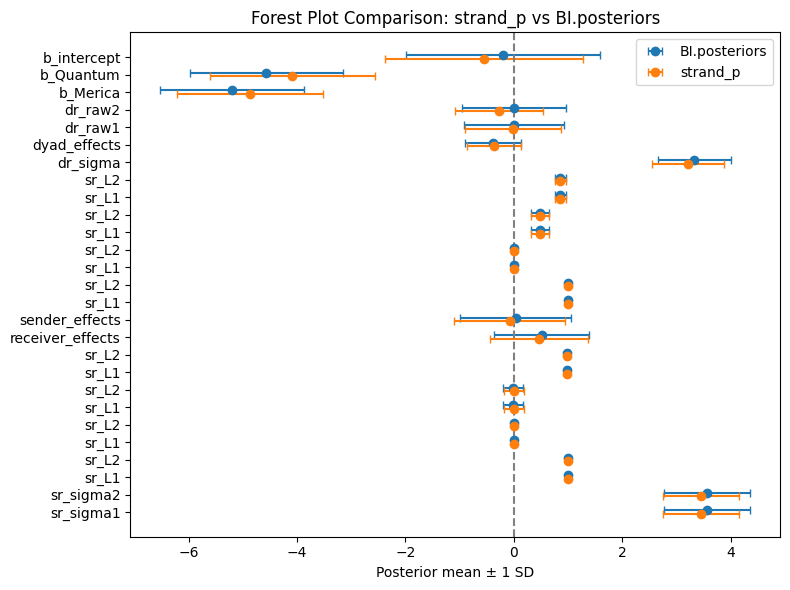

In [253]:
from rpy2.robjects.vectors import (
    ListVector, FloatVector, FloatMatrix,
    IntVector, IntMatrix, StrVector
)
from rpy2.rinterface import NULLType
import numpy as np
from jax import vmap
def r_to_py(obj, block_names=None):
    """
    Recursively convert an R object (from rpy2) into a native Python structure.
    Custom names can be given to subelements of 'block_parameters',
    and they will be lifted into the main dictionary.
    """
    
    if isinstance(obj, ListVector):
        if isinstance(obj.names, NULLType) or obj.names is None:
            return [r_to_py(el, block_names=block_names) for el in obj]
        else:
            names = [str(n) for n in obj.names]
            result = {}
            for name in names:
                element = obj.rx2(str(name))
                if name == "block_parameters" and block_names is not None:
                    sublist = [r_to_py(el, block_names=block_names) for el in element]
                    # Assign names if lengths match
                    if len(block_names) == len(sublist):
                        # Merge directly into main dict
                        for bn, val in zip(block_names, sublist):
                            result[bn] = val
                    else:
                        # fallback: keep under 'block_parameters'
                        result[name] = sublist
                else:
                    result[name] = r_to_py(element, block_names=block_names)
            return result
    
    elif isinstance(obj, (FloatMatrix, IntMatrix)):
        return np.array(obj)
    
    elif isinstance(obj, (FloatVector, IntVector)):
        return np.array(obj)
    
    elif isinstance(obj, StrVector):
        return list(obj)
    
    elif isinstance(obj, NULLType):
        return None
    
    else:
        return obj

strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = r_to_py(strand_posteriors, block_names=['b_intercept', 'b_Merica', 'b_Quantum'])
strand_posteriors.keys()
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

##### Checking posteriors

In [254]:
def Compare_matrix(BI_post, STRAND_post, name):
    BI_mean = BI_post.mean(axis = 0).flatten()
    STRAND_mean = STRAND_post.mean(axis = 0).flatten()

    BI_error_low = np.percentile(BI_post, [2.5], axis = 0).flatten()
    STRAND_error_low = np.percentile(STRAND_post, [2.5], axis = 0).flatten()

    BI_error_high = np.percentile(BI_post, [97.5], axis = 0).flatten()
    STRAND_error_high = np.percentile(STRAND_post, [97.5], axis = 0).flatten()

    BI_yerr = jnp.stack([BI_mean - BI_error_low, BI_error_high - BI_mean])
    STRAND_yerr = jnp.stack([STRAND_mean - STRAND_error_low, STRAND_error_high - STRAND_mean])

    x = jnp.arange(len(BI_mean))
    plt.figure(figsize=(10, 5))
    plt.errorbar(x, STRAND_mean, yerr=STRAND_yerr, fmt='o', capsize=5, markersize=5)
    plt.errorbar(x, BI_mean, yerr=BI_yerr, fmt='o', capsize=5, markersize=5)
    plt.legend(['STRAND', 'BI'])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Posterior means with 95% credible intervals for {name}')
    plt.show()

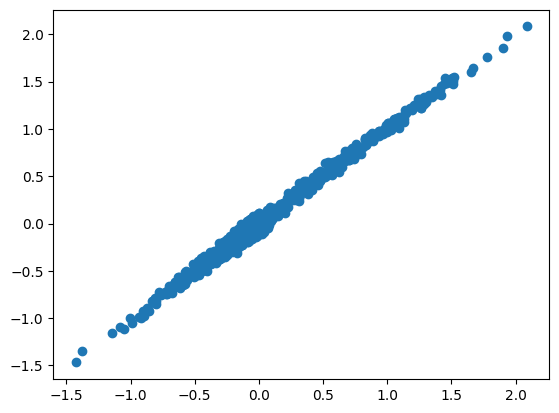

In [255]:
import matplotlib.pyplot as plt
STRAND_dr_raw_mean = strand_posteriors['dyadic_random_effects'].mean(axis = 0)
STRAND_dr_raw_mean_edgl = m.net.mat_to_edgl(STRAND_dr_raw_mean)
STRAND_dr_raw_mean_edgl.shape

BI_dr_raw_mean_edgl = m.posteriors['dr_raw'].mean(axis = 0).transpose(1,0)
BI_dr_raw_mean_edgl.shape

plt.scatter(STRAND_dr_raw_mean_edgl,BI_dr_raw_mean_edgl)

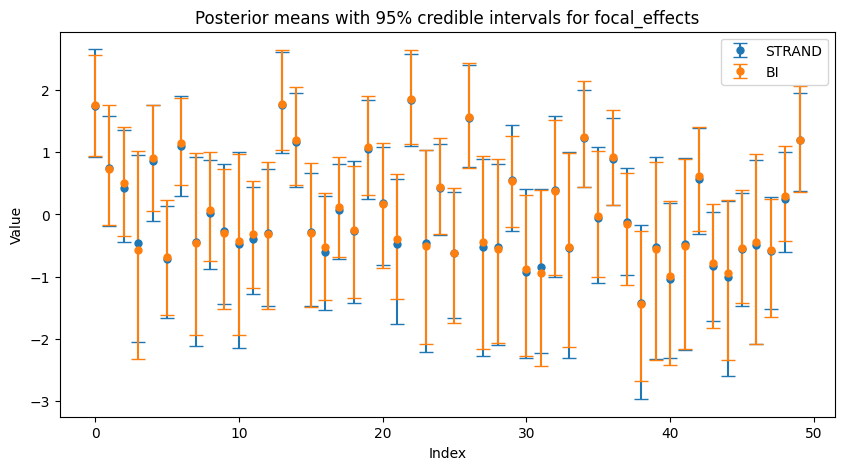

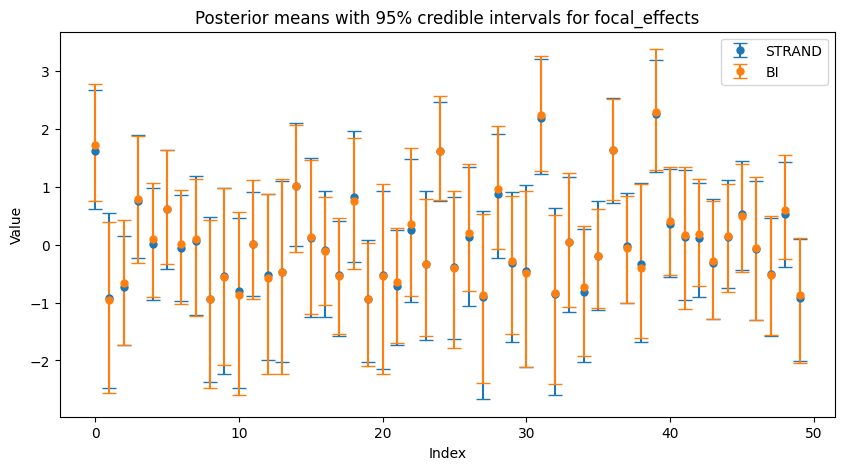

In [256]:
Compare_matrix(
    m.posteriors['sr_raw'].transpose(0,2,1)[:,:,0], 
    strand_posteriors['focal_target_random_effects'][:,:,0], 
    name='focal_effects'
)
Compare_matrix(
    m.posteriors['sr_raw'].transpose(0,2,1)[:,:,1], 
    strand_posteriors['focal_target_random_effects'][:,:,1],
    name='focal_effects'
)

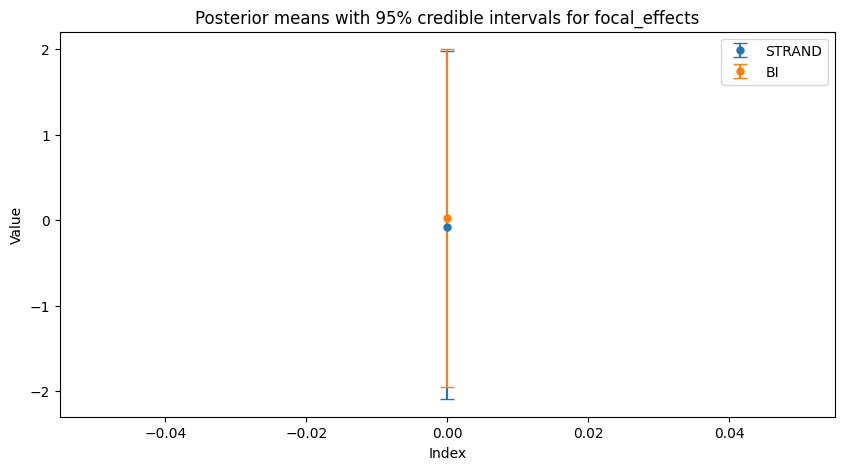

In [257]:
Compare_matrix(m.posteriors['sender_effects'], strand_posteriors['focal_coeffs'], name='focal_effects')

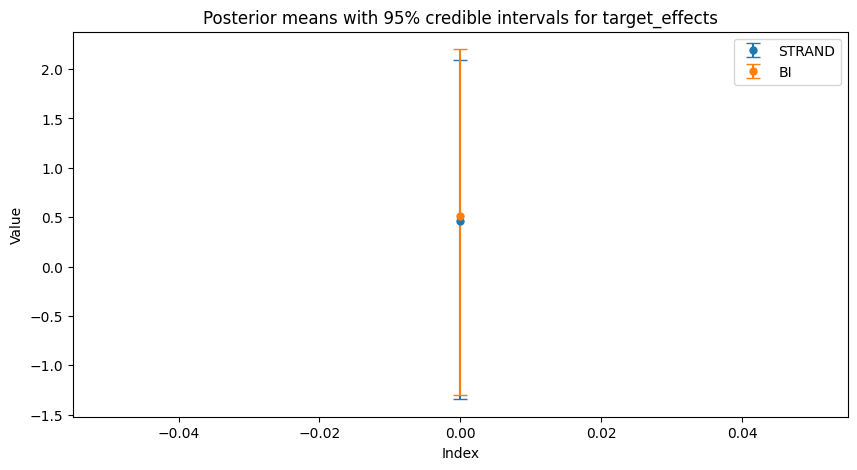

In [258]:
Compare_matrix(m.posteriors['receiver_effects'][:,1], strand_posteriors['target_coeffs'], name='target_effects')

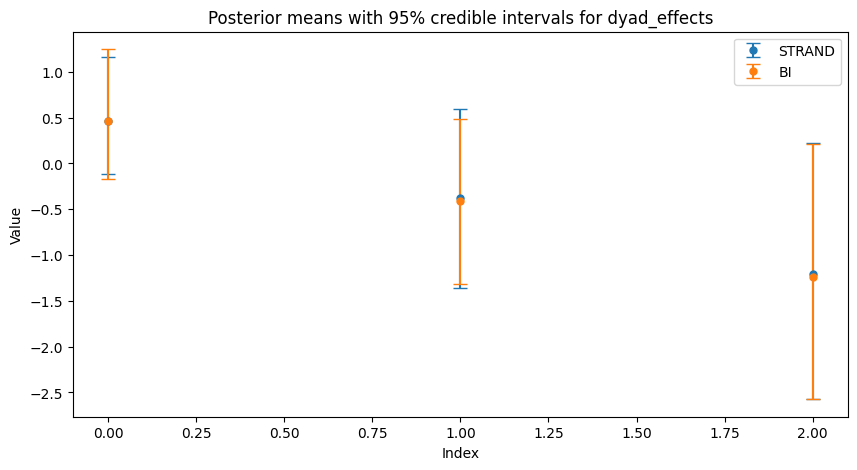

In [259]:
Compare_matrix(m.posteriors['dyad_effects'], strand_posteriors['dyadic_coeffs'], name='dyad_effects')

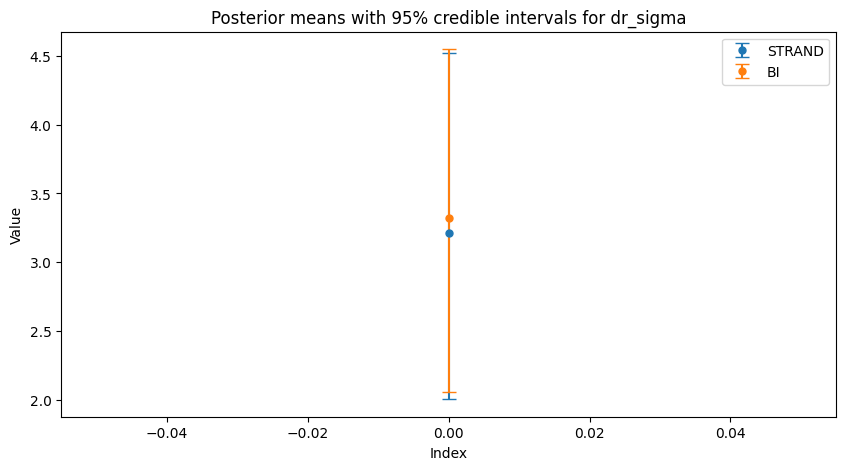

In [260]:
Compare_matrix(m.posteriors['dr_sigma'][:,1], strand_posteriors['dyadic_sd'], name='dr_sigma')

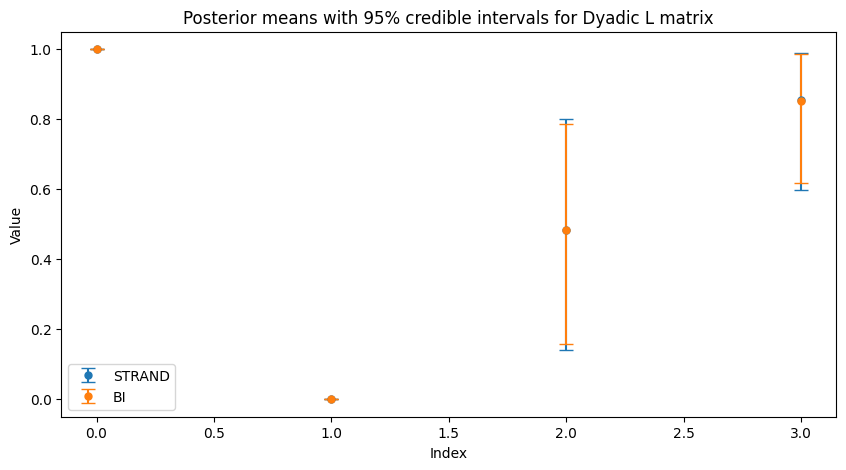

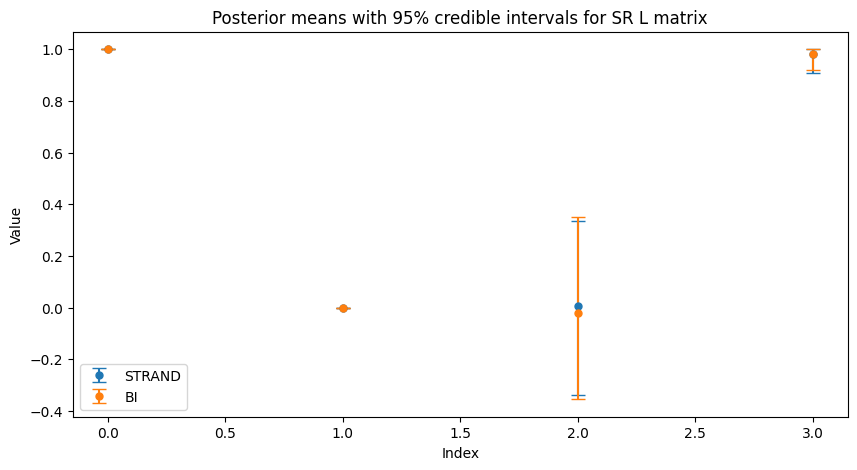

In [261]:

Compare_matrix(m.posteriors['dr_L'], strand_posteriors['dyadic_L'], name='Dyadic L matrix')
Compare_matrix(m.posteriors['sr_L'], strand_posteriors['focal_target_L'], name='SR L matrix')

In [ ]:
def Block_posterior_comparison(strand_posteriors, bi_posteriors):
    mean = []
    error_low = []
    error_high = []
    for k in strand_posteriors.keys():
        if 'b_' in k:
            mean.append(strand_posteriors[k].mean(axis = 0).T.flatten())
            error_low.append(np.percentile(strand_posteriors[k], [2.5], axis = 0).T.flatten())
            error_high.append(np.percentile(strand_posteriors[k], [97.5], axis = 0).T.flatten())

    mean = jnp.concat(mean)
    error_low  = jnp.concat(error_low)
    error_high  = jnp.concat(error_high)
    # Compute symmetric error for matplotlib
    yerr = jnp.stack([mean - error_low, error_high - mean])

    # X-axis
    x = jnp.arange(len(mean))

    # BI
    BI_block_effects = bi_posteriors['block_effects'] 
    mean_BI = BI_block_effects.mean(axis = 0).flatten()
    error_low_BI = np.percentile(BI_block_effects, [2.5], axis = 0).flatten()
    error_high_BI = np.percentile(BI_block_effects, [97.5], axis = 0).flatten()
    yerr_BI = np.stack((mean_BI - error_low_BI, error_high_BI - mean_BI))

    plt.figure(figsize=(10, 5))
    plt.errorbar(x, mean, yerr=yerr, fmt='o', capsize=5, markersize=5)
    plt.errorbar(x, mean_BI, yerr=yerr_BI, fmt='o', capsize=5, markersize=5)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Posterior means with 95% credible intervals for block effects')
    plt.show()

Block_posterior_comparison(strand_posteriors, m.posteriors)

Another appraoch approach

In [ ]:


def block_build_mu_ij(group, N_by_group, N_group):
    # N_group is  a static value known at compile time.
    base_rate = jnp.tile(0.01, (N_group, N_group))
    base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
    mu_ij = base_rate / jnp.sqrt(jnp.outer(N_by_group*0.5 , N_by_group*0.5))
    return mu_ij

Any_edgl = m.net.vec_to_edgl(Any.astype(jnp.int32))
Merica_edgl = m.net.vec_to_edgl(Merica.astype(jnp.int32))
Quantum_edgl = m.net.vec_to_edgl(Quantum.astype(jnp.int32))

B_Merica = block_build_mu_ij(Merica, N_per_grp_Merica, jnp.array(N_grp_Merica))
B_quantum = block_build_mu_ij(Quantum, N_per_gr_Quantum, jnp.array(N_grp_Quantum))
B_any = block_build_mu_ij(Any, N_per_grp_Any, jnp.array(N_grp_Any))

    
B_priors_Merica_edgl = jnp.stack([
        B_Merica[Merica_edgl[:,0], Merica_edgl[:,1]], 
        B_Merica[Merica_edgl[:,1], Merica_edgl[:,0]]
    ]).T
B_priors_Quantum_edgl = jnp.stack(
    [
        B_quantum[Quantum_edgl[:,0], Quantum_edgl[:,1]], 
        B_quantum[Quantum_edgl[:,1], Merica_edgl[:,0]]
    ]).T
B_priors_Any_edgl = jnp.stack(
    [
        B_any[Merica_edgl[:,0], Any_edgl[:,1]], 
        B_any[Any_edgl[:,1], Any_edgl[:,0]]
    ]).T
B_factors = jnp.stack([Any_edgl, Merica_edgl, Quantum_edgl], axis=1).transpose(0,2,1)

block_mu = jnp.stack([B_priors_Merica_edgl, B_priors_Quantum_edgl, B_priors_Any_edgl], axis=2)
block_sigma = jnp.full(block_mu.shape, 2.5)
block_effects = m.dist.normal(loc=block_mu, scale=block_sigma, sample = True)
print(B_factors.shape)
print(block_effects.shape)
print(block_sigma.shape)


(1225, 2, 3)
(1225, 2, 3)
(1225, 2, 3)


###### New block approach

In [ ]:
%%R
block_set_to_dyadic_block_set = function(x, priors = NULL){
    N_vars = ncol(x)
    N_id = nrow(x)
    N_groups_per_var = rep(NA, N_vars)

    for(v in 1:N_vars){
     N_groups_per_var[v] = max(x[,v])
    }

    max_N_groups_per_var = max(N_groups_per_var)

    N_per_group = matrix(1, nrow=N_vars, ncol=max_N_groups_per_var)

    for(v in 1:N_vars){
     N_per_group[v,1:N_groups_per_var[v]] = table(x[,v])
    }

    N_pars = sum(N_groups_per_var^2)

    N_groups_per_var2 = N_groups_per_var^2

    ################################### Parameter structure
    B_V = B_I = B_J = B_In = B_Base = B_SS = array(0, c(N_vars, max_N_groups_per_var, max_N_groups_per_var))

    if(is.null(priors)){
     block_priors =  make_priors()
      } else{
     block_priors = priors
      }

    for(v in 1:N_vars){
    for(i in 1:N_groups_per_var[v]){
    for(j in 1:N_groups_per_var[v]){
     B_V[v,i,j] = v
     B_I[v,i,j] = i
     B_J[v,i,j] = j
     B_In[v,i,j] = 1
     B_Base[v,i,j] = ifelse(i==j, block_priors[10,1], block_priors[11,1])
     B_SS[v,i,j] = sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5)
      }
     }
    }

    dat = data.frame(V = c(B_V), I = c(B_I), J = c(B_J), In = c(B_In), Base = c(B_Base), SS = c(B_SS))

    dat2 = dat[which(dat$In==1),]

    dat2$Mu = logit(dat2$Base/dat2$SS)

    if(block_priors[10,1] == block_priors[11,1]){
        stop("block_priors[10,1] and block_priors[11,1] may not be identical. Add at least a tiny offset.")
    }
    
    dat2$Sigma = ifelse(dat2$Base == block_priors[10,1], block_priors[10,2], block_priors[11,2])

    dat2 = dat2[order(dat2$V),]

    ########## Build binary tensor

     Y = array(0, c(N_id, N_id, N_pars))

     for(i in 1:N_id){
        for(j in 1:N_id){
             scrap_i = scrap_j = rep(0, N_pars)
          for(v in 1:N_vars){
              scrap_i[which(dat2$V==v & dat2$I==x[i,v])] = 1
              scrap_j[which(dat2$V==v & dat2$J==x[j,v])] = 1
              }
            Y[i,j,] = scrap_i*scrap_j
            }
        }
     
    return(list(Y=Y, Mu=c(dat2$Mu), Sigma=c(dat2$Sigma)))

    }
res = block_set_to_dyadic_block_set(fit1$data$block_set)
dim(res$Y)

[1] 50 50 14
 50 50 14


In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
R.version.string

[1] "R version 4.3.3 (2024-02-29)"
 "R version 4.3.3 (2024-02-29)"


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import conversion
import rpy2.robjects.pandas2ri as pandas2ri
import numpy as np

def r_to_py(r_obj, block_names=None):
    """
    Converts an R object from rpy2 into a native Python structure,
    and optionally transforms it by lifting and renaming elements 
    from a 'block_parameters' list into the main dictionary.

    Args:
        r_obj: The rpy2 object to convert.
        block_names (list, optional): A list of new string names for the elements 
                                      within the 'block_parameters' list. If provided,
                                      these elements will be moved to the top level
                                      of the dictionary with the new names.

    Returns:
        A native Python object (e.g., dict, list, numpy array).
    """
    # --- Step 1: Perform a robust, full conversion to a Python object ---
    # This uses rpy2's modern context manager to handle all R types correctly.
    with conversion.localconverter(ro.default_converter + pandas2ri.converter):
        py_obj = ro.conversion.rpy2py(r_obj)

    # --- Step 2: Apply the custom transformation if conditions are met ---
    # This logic now operates on a simple Python dictionary, not complex rpy2 types.
    
    # The transformation only makes sense if the object is a dictionary and block_names are given.
    if block_names and isinstance(py_obj, dict) and "block_parameters" in py_obj:
        
        # Make a copy to hold the transformed result.
        transformed_obj = py_obj.copy()
        
        # Remove the original 'block_parameters' key and get its value.
        block_params_list = transformed_obj.pop("block_parameters")
        
        # Ensure the list and names have matching lengths to avoid errors.
        if isinstance(block_params_list, list) and len(block_names) == len(block_params_list):
            # "Lift" the elements by adding them to the top-level dict with new names.
            for name, value in zip(block_names, block_params_list):
                transformed_obj[name] = value
            return transformed_obj
        else:
            # If lengths don't match, return the original object to prevent data loss.
            # A warning could be added here if desired.
            return py_obj
    
    # If no transformation is requested or possible, return the directly converted object.
    return py_obj



In [ ]:
from jax import vmap
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

['b_Merica', 'b_Quantum', 'b_intercept']
b_Merica
b_Quantum
b_intercept
dict_keys(['sr_sigma', 'sr_L', 'receiver_effects', 'sender_effects', 'dr_L', 'dr_sigma', 'dyad_effects', 'dr_raw', 'b_Merica', 'b_Quantum', 'b_intercept'])
dict_values(['focal_target_sd', 'focal_target_L', 'target_coeffs', 'focal_coeffs', 'dyadic_L', 'dyadic_sd', 'dyadic_coeffs', 'dyadic_random_effects', 'b_Merica', 'b_Quantum', 'b_intercept'])


KeyError: 'receiver_effects'

# New block approach

In [ ]:
def import_block_predictors(block_predictors, names = None, index1 = False):
        #! index1 for R users
        N_id = block_predictors.shape[0]
        if block_predictors.ndim > 1:
            N_vars = block_predictors.shape[1]
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = max(N_groups_per_var)
        else:
            N_vars = 1
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = jnp.array([1])
        jnp.unique(block_predictors, return_counts=True)
        N_per_group = jnp.ones((N_vars, max_N_groups_per_var))
        for a in range(N_vars):
            N_per_group = N_per_group.at[a,:N_groups_per_var[a]].set(jnp.unique(block_predictors[:,a], return_counts = True)[1])
        N_per_group
        N_pars = (N_groups_per_var * N_groups_per_var).sum()
    
        B_V = B_I = B_J = B_In = B_Base = B_SS = jnp.zeros((N_vars, max_N_groups_per_var, max_N_groups_per_var))
        for v in range(N_vars):
            for i in range(N_groups_per_var[v]):
                for j in range(N_groups_per_var[v]):
                    B_V= B_V.at[v,i,j].set(v)
                    B_I = B_I.at[v,i,j].set(i)
                    B_J= B_J.at[v,i,j].set(j)
                    B_In = B_In.at[v,i,j].set(1)
                    B_Base =  B_Base.at[v,i,j].set(0.1 if i == j else 0.01)        
                    B_SS = B_SS.at[v,i,j].set(jnp.sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5))
    
        B_SS = B_SS.flatten()
        B_V = B_V.flatten()
        B_I = B_I.flatten()
        B_J = B_J.flatten()
        B_In = B_In.flatten()
        B_Base = B_Base.flatten()
        dat_B = jnp.stack([B_V, B_I, B_J, B_In, B_Base, B_SS], axis = -1)
        dat_B = dat_B[jnp.where(B_In==1)]
        Sigma = jnp.full((N_pars,), 2.5)
        Mu = m.link.logit(dat_B[:,-2]/dat_B[:,-1])
    
        dat_B = jnp.concatenate([dat_B, Mu[:,None], Sigma[:,None]], axis = 1)


        def build_block_tensor(dat_B, block_predictors):
            dat_B2 = dat_B[:, :3].astype(int)
            dat_B2_col0 = dat_B2[:, 0]
            dat_B2_col1 = dat_B2[:, 1]
            dat_B2_col2 = dat_B2[:, 2]
            block_preds_indexed = block_predictors[:, dat_B2_col0]
            scrap_i_matrix = (block_preds_indexed == dat_B2_col1)
            scrap_j_matrix = (block_preds_indexed == dat_B2_col2)
            # 5. Transpose the matrices to get a shape of (N_pars, N_id)
            scrap_i_T = scrap_i_matrix.T
            scrap_j_T = scrap_j_matrix.T
            Y_optimized = (scrap_i_T[:, :, np.newaxis] * scrap_j_T[:, np.newaxis, :]).astype(int)
            return  jnp.array(Y_optimized.transpose(1,2,0))
        
        block_tensor = build_block_tensor(dat_B, block_predictors)

        Block_edgl =  []
        for a in range(block_tensor.shape[2]):
            Block_edgl.append(m.net.mat_to_edgl(block_tensor[:,:,a]))  
        Block_edgl = jnp.transpose(jnp.stack(Block_edgl), (1,2,0))

        Block_edgl = Block_edgl
        dat_B = dat_B
        block_names = names
        N_vars_Block = N_vars
        max_N_groups_per_var = max_N_groups_per_var
        N_pars = N_pars
        if index1:
            block_predictors = block_predictors - 1
        else:
            block_predictors = block_predictors

        return dat_B, Block_edgl

def block_effect_srm_class(block_predictors, names = ['Any', 'Merica', 'Quantum'], index1 = True, sample = False):
    dat_B, block_edgl = import_block_predictors(block_predictors = block_predictors, names = ['Any', 'Merica', 'Quantum'], index1 = True)
    coefs = m.dist.normal(dat_B[:,-2], dat_B[:,-1], name = 'block_effects',  sample = sample)
    t = jnp.sum(coefs * block_edgl, axis=2)
    return jnp.stack([t[:,1], t[:,0]]).T


In [ ]:
def model(network, dyadic_predictors, sender_predictors, receiver_predictors,block_predictors):
    # Block ---------------------------------------
    #B = block_effect_srm_class(srm)
    B = block_effect_srm_class(block_predictors)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(sender_predictors, receiver_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(shape = sr.shape[0])

    m.dist.bernoulli(logits = B + sr + dr , obs=network, name = 'network')
m.data_on_model = dict(
    block_predictors = block_predictors,
    network = network, 
    dyadic_predictors = dyadic_predictors, # Can be a jax array of multiple dimensions
    sender_predictors = sender_predictors,
    receiver_predictors = receiver_predictors
)

m.fit(model)
m.summary()

## BISONR (WIP)

In [ ]:
df = pd.read_csv('tests/STRAND/bison sim data.csv')
df.shape

(45, 7)

### Binary

In [ ]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

In [ ]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [ ]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = bi.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

R[write to console]: Model executable is up to date!



Running R model with bisonR...
Running MCMC with 4 parallel chains...

Chain 1 finished in 0.1 seconds.
Chain 2 finished in 0.1 seconds.
Chain 3 finished in 0.1 seconds.
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.7 seconds.


R Data summary:
  Number of observations: 45
  Event mean: 1.6000
  Event range: [0.0000, 5.0000]
# A tibble: 181 × 10
   variable      mean median    sd   mad      q5     q95  rhat ess_bulk ess_tail
   <chr>        <dbl>  <dbl> <dbl> <dbl>   <dbl>   <dbl> <dbl>    <dbl>    <dbl>
 1 lp__        -65.9  -65.5   4.87  4.82 -74.2   -58.4   1.00     1886.    2735.
 2 edge_weigh…   2.55   2.38  1.57  1.56   0.294   5.36  1.00     4675.    2770.
 3 edge_weigh…   1.62   1.51  1.84  1.80  -1.26    4.77  1.00     5236.    3173.
 4 edge_weigh…  -2.74  -2.59  1.53  1.47  -5.55   -0.577 1.00     3928.    2622.
 5 edge_weigh…   2.76   2.58  1.52  1.42   0.513   5.52  1.000    4890.    288

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
     edge_sigma      0.79      0.62      0.65      0.00      1.66   5806.17      1.00
 edge_weight[0]      0.38      0.92      0.37     -1.13      1.91   6491.20      1.00
 edge_weight[1]      0.19      0.90      0.17     -1.29      1.64   6206.38      1.00
 edge_weight[2]     -0.63      1.13     -0.64     -2.36      1.40   7477.51      1.00
 edge_weight[3]      0.39      0.89      0.37     -1.07      1.82   6957.65      1.00
 edge_weight[4]      0.36      0.93      0.36     -1.25      1.82   6269.30      1.00
 edge_weight[5]      0.40      0.92      0.39     -1.12      1.86   6294.47      1.00
 edge_weight[6]      0.39      0.90      0.40     -1.11      1.81   5992.26      1.00
 edge_weight[7]      0.39      0.89      0.37     -1.00      1.92   5397.52      1.00
 edge_weight[8]      0.21      0.93      0.19     -1.23      1.77   5877.70      1.00
 edge_weight[9]      0.38      0.92      0.37     -1.

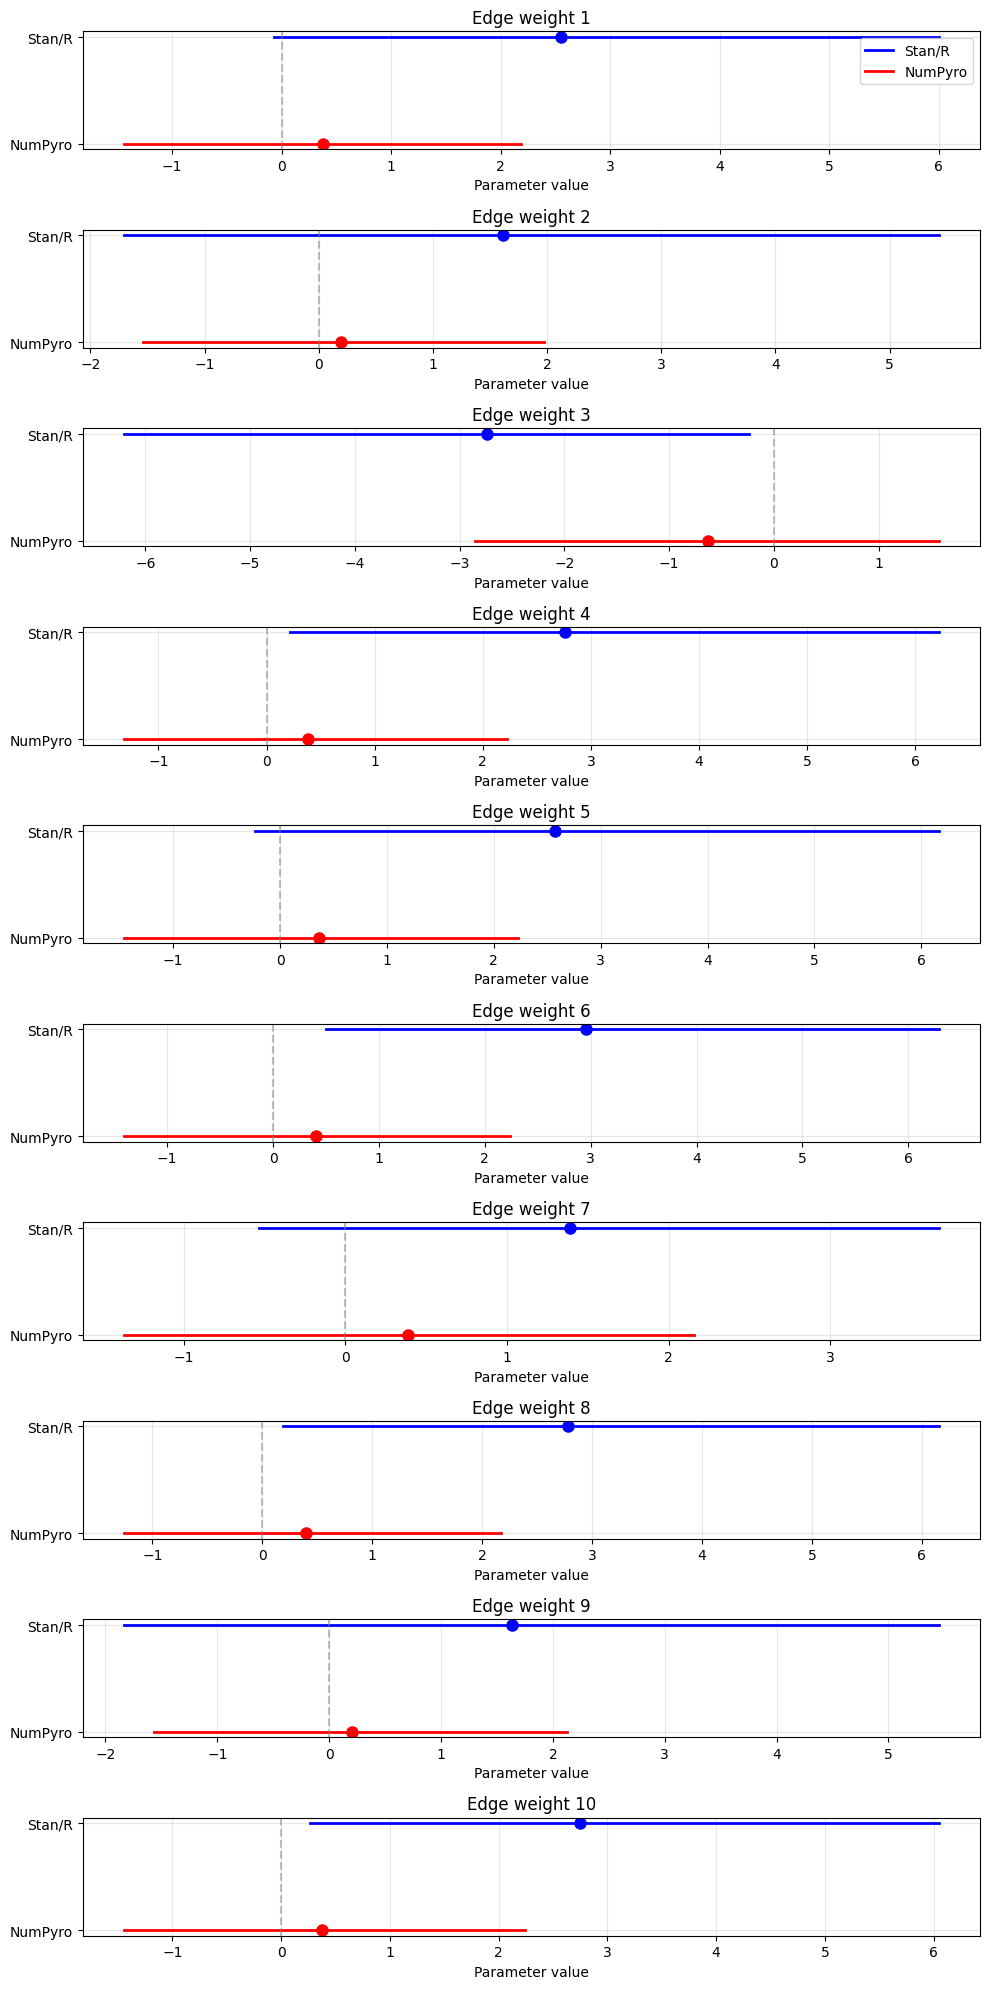


Comparison complete!


In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
from jax import random
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Enable automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Set random seeds for reproducibility
np.random.seed(42)

def numpyro_bison_model(
    event, event_count, divisor, dyad_ids, dyad_ids_receiver,
    design_fixed, design_random, random_group_index,
    num_edges, num_fixed, num_random, num_random_groups,
    prior_edge_mu, prior_edge_sigma, prior_fixed_mu, prior_fixed_sigma,
    prior_random_mean_mu, prior_random_mean_sigma, prior_random_std_sigma,
    prior_zero_prob_alpha, prior_zero_prob_beta, prior_rate_sigma,
    priors_only=False, partial_pooling=False, zero_inflated=False, sender_receiver=False
):
    """NumPyro version of the Stan bison model"""
    
    num_rows = len(event)
    
    # Parameters - sample rate first since it's used in likelihood
    if num_edges > 0:
        # Rate parameter: In Stan it's vector<lower=0> with normal(0, sigma) prior
        # This creates a truncated normal (half-normal when mu=0)
        # In NumPyro, we use TruncatedNormal or HalfNormal
        edge_sigma = numpyro.sample('edge_sigma', dist.HalfNormal(prior_edge_sigma))
        with numpyro.plate('edges', num_edges):
            rate = numpyro.sample('rate', dist.HalfNormal(prior_rate_sigma))
        
            # Edge weights
            if partial_pooling:
                edge_weight = numpyro.sample('edge_weight', dist.Normal(prior_edge_mu, edge_sigma))
            else:
                edge_weight = numpyro.sample('edge_weight', dist.Normal(prior_edge_mu, prior_edge_sigma))
    else:
        edge_weight = jnp.zeros(1)
        rate = jnp.ones(1)
    
    if num_fixed > 0:
        beta_fixed = numpyro.sample('beta_fixed', dist.Normal(prior_fixed_mu, prior_fixed_sigma).expand([num_fixed]))
    else:
        beta_fixed = jnp.zeros(1)
    
    if num_random > 0:
        random_group_mu = numpyro.sample('random_group_mu', 
                                         dist.Normal(prior_random_mean_mu, prior_random_mean_sigma).expand([num_random_groups]))
        random_group_sigma = numpyro.sample('random_group_sigma', 
                                            dist.HalfNormal(prior_random_std_sigma).expand([num_random_groups]))
        
        # Sample random effects with proper indexing
        beta_random = numpyro.sample('beta_random', 
                                     dist.Normal(random_group_mu[random_group_index], 
                                               random_group_sigma[random_group_index]))
    else:
        beta_random = jnp.zeros(1)
    
    if zero_inflated:
        zero_prob = numpyro.sample('zero_prob', dist.Beta(prior_zero_prob_alpha, prior_zero_prob_beta))
    
    # Transformed parameters - build predictor
    predictor = jnp.zeros(num_rows)
    
    if num_edges > 0:
        predictor = predictor + edge_weight[dyad_ids]
    
    if num_fixed > 0:
        predictor = predictor + jnp.dot(design_fixed, beta_fixed)
    
    if num_random > 0:
        predictor = predictor + jnp.dot(design_random, beta_random)
    
    # Likelihood
    if not priors_only:
        if not zero_inflated:
            # Standard exponential model
            # Stan: rate[dyad_ids] ./ inv_logit(predictor)
            # inv_logit(x) = 1/(1+exp(-x)) = sigmoid(x)
            # So this is: rate / sigmoid(predictor)
            inv_logit_predictor = jax.nn.sigmoid(predictor)
            rate_param = rate[dyad_ids] / inv_logit_predictor
            
            # Make sure rate_param is positive
            rate_param = jnp.maximum(rate_param, 1e-8)
            
            with numpyro.plate('obs_plate', num_rows):
                numpyro.sample('obs', dist.Exponential(rate_param), obs=event)
        else:
            # Zero-inflated model
            inv_logit_predictor = jax.nn.sigmoid(predictor)
            rate_param = rate[dyad_ids] / inv_logit_predictor
            rate_param = jnp.maximum(rate_param, 1e-8)
            
            with numpyro.plate('obs_plate', num_rows):
                numpyro.sample('obs', dist.Exponential(rate_param), obs=event)


def run_r_model():
    """Run the R bisonR model and extract results"""
    print("Running R model with bisonR...")
    
    # Load R libraries
    ro.r('library(bisonR)')
    
    # Simulate data
    ro.r('''
    set.seed(42)
    sim_data <- simulate_bison_model("binary", aggregated = TRUE)
    df <- sim_data$df_sim
    priors <- get_default_priors("binary")
    ''')
    
    # Fit model
    ro.r('''
    fit_edge <- bison_model(
      (event | duration) ~ dyad(node_1_id, node_2_id), 
      data=df, 
      model_type="binary",
      priors=priors
    )
    ''')
    
    # Extract data for NumPyro
    df = ro.r('df')
    df = pandas2ri.rpy2py(df)
    
    print(f"\nR Data summary:")
    print(f"  Number of observations: {len(df)}")
    print(f"  Event mean: {df['event'].mean():.4f}")
    print(f"  Event range: [{df['event'].min():.4f}, {df['event'].max():.4f}]")
    
    # Extract posterior samples from CmdStanMCMC object
    # Use the draws() method to get posterior samples as a data frame
    ro.r('''
    posterior_samples <- fit_edge$fit$draws(format = "df")
    posterior_samples <- as.data.frame(posterior_samples)
    ''')
    posterior_df = ro.r('posterior_samples')
    posterior_df = pandas2ri.rpy2py(posterior_df)
    
    # Get summary
    ro.r('''
    fit_summary <- fit_edge$fit$summary()
    print(fit_summary)
    ''')
    
    # Print some edge weight summaries
    print("\nStan/R edge weight summary (first 5):")
    edge_cols = [col for col in posterior_df.columns if col.startswith('edge_weight[')]
    for i, col in enumerate(edge_cols[:5]):
        vals = posterior_df[col].values
        print(f"  {col}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}")
    
    return df, posterior_df


def run_numpyro_model(df):
    """Run NumPyro version of the model"""
    print("Running NumPyro model...")
    
    # Prepare data
    event = jnp.array(df['event'].values, dtype=jnp.float32)
    divisor = jnp.array(df['duration'].values, dtype=jnp.float32)
    
    # Create dyad IDs (0-indexed for Python)
    unique_dyads = df[['node_1_id', 'node_2_id']].drop_duplicates()
    dyad_map = {tuple(row): idx for idx, row in enumerate(unique_dyads.values)}
    dyad_ids = jnp.array([dyad_map[tuple(row)] for row in df[['node_1_id', 'node_2_id']].values])
    
    num_edges = len(unique_dyads)
    num_rows = len(event)
    
    print(f"Data summary:")
    print(f"  Number of observations: {num_rows}")
    print(f"  Number of unique dyads: {num_edges}")
    print(f"  Event mean: {np.mean(event):.4f}")
    print(f"  Event range: [{np.min(event):.4f}, {np.max(event):.4f}]")
    
    # Set priors (using defaults from bisonR)
    prior_edge_mu = 0.0
    prior_edge_sigma = 1.0
    prior_rate_sigma = 1.0
    
    # Run MCMC
    nuts_kernel = NUTS(numpyro_bison_model, max_tree_depth=10)
    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
    
    rng_key = random.PRNGKey(42)
    mcmc.run(
        rng_key,
        event=event,
        event_count=jnp.zeros(num_edges),  # Placeholder
        divisor=divisor,
        dyad_ids=dyad_ids,
        dyad_ids_receiver=dyad_ids,  # Placeholder
        design_fixed=jnp.zeros((num_rows, 0)),
        design_random=jnp.zeros((num_rows, 0)),
        random_group_index=jnp.array([], dtype=jnp.int32),
        num_edges=num_edges,
        num_fixed=0,
        num_random=0,
        num_random_groups=0,
        prior_edge_mu=prior_edge_mu,
        prior_edge_sigma=prior_edge_sigma,
        prior_fixed_mu=0.0,
        prior_fixed_sigma=1.0,
        prior_random_mean_mu=0.0,
        prior_random_mean_sigma=1.0,
        prior_random_std_sigma=1.0,
        prior_zero_prob_alpha=1.0,
        prior_zero_prob_beta=1.0,
        prior_rate_sigma=prior_rate_sigma,
        priors_only=False,
        partial_pooling=False,
        zero_inflated=False,
        sender_receiver=False
    )
    
    mcmc.print_summary(exclude_deterministic=False)
    samples = mcmc.get_samples()
    
    # Print some diagnostics
    print("\nNumPyro edge weight summary (first 5):")
    for i in range(min(5, num_edges)):
        ew = samples['edge_weight'][:, i]
        print(f"  edge_weight[{i}]: mean={np.mean(ew):.4f}, std={np.std(ew):.4f}")
    
    return samples, num_edges


def plot_comparison(r_posterior, numpyro_samples, num_edges):
    """Create forest plot comparing Stan and NumPyro results"""
    print("Creating forest plot comparison...")
    
    # Select parameters to compare (edge weights)
    params_to_compare = min(10, num_edges)  # Compare first 10 edge weights
    
    fig, axes = plt.subplots(params_to_compare, 1, figsize=(10, 2*params_to_compare))
    if params_to_compare == 1:
        axes = [axes]
    
    for i in range(params_to_compare):
        ax = axes[i]
        
        # R/Stan results
        param_name = f'edge_weight[{i+1}]'  # R uses 1-indexing
        if param_name in r_posterior.columns:
            r_samples = r_posterior[param_name].values
            r_mean = np.mean(r_samples)
            r_ci = np.percentile(r_samples, [2.5, 97.5])
            
            ax.plot([r_ci[0], r_ci[1]], [1, 1], 'b-', linewidth=2, label='Stan/R')
            ax.plot(r_mean, 1, 'bo', markersize=8)
        
        # NumPyro results
        numpyro_param = numpyro_samples['edge_weight'][:, i]
        np_mean = np.mean(numpyro_param)
        np_ci = np.percentile(numpyro_param, [2.5, 97.5])
        
        ax.plot([np_ci[0], np_ci[1]], [0, 0], 'r-', linewidth=2, label='NumPyro')
        ax.plot(np_mean, 0, 'ro', markersize=8)
        
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['NumPyro', 'Stan/R'])
        ax.set_xlabel('Parameter value')
        ax.set_title(f'Edge weight {i+1}')
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.legend()
    
    plt.tight_layout()
    plt.savefig('stan_numpyro_comparison.png', dpi=300, bbox_inches='tight')
    print("Forest plot saved as 'stan_numpyro_comparison.png'")
    plt.show()


def main():
    """Main comparison workflow"""
    try:
        # Run R model
        df, r_posterior = run_r_model()
        
        # Run NumPyro model
        numpyro_samples, num_edges = run_numpyro_model(df)
        
        # Compare results
        plot_comparison(r_posterior, numpyro_samples, num_edges)
        
        
    except Exception as e:
        print(f"Error during comparison: {e}")
        print("\nNote: This requires:")
        print("- R with bisonR package installed")
        print("- rpy2 Python package")
        print("- NumPyro and JAX")


if __name__ == "__main__":
    main()